In [1]:
%matplotlib inline

# Preprocessing and LFP Plotting

## TODO: Add the preprocessing steps from https://github.com/SpikeInterface/spiketutorials/blob/master/Official_Tutorial_SI_0.94_May2022/SpikeInterface_Tutorial.ipynb

# References

In [2]:
channel_id_to_brain_region = {"13": "LH", "14": "BLA", "15": "vHPC", "21": "mPFC", "16":"MD" }

In [3]:
trial_type_to_color = {"rewarded": "orange", "win": "green", "omission": "red", "lose": "blue"}

In [4]:
subject_id = "6.3"

# Chapter 2: Preprocessing Recording

In [5]:
import os
import warnings
import glob
import pickle
import _pickle as cPickle
import importlib

In [6]:
from collections import defaultdict
import time
import json

In [7]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import pandas as pd
import scipy.signal
from scipy import stats

In [8]:
from spectral_connectivity import Multitaper, Connectivity

In [9]:
# Changing the figure size
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

The spikeinterface module by itself import only the spikeinterface.core submodule
which is not useful for end user



In [10]:
import spikeinterface

We need to import one by one different submodules separately (preferred).
There are 5 modules:

- :code:`extractors` : file IO
- :code:`toolkit` : processing toolkit for pre-, post-processing, validation, and automatic curation
- :code:`sorters` : Python wrappers of spike sorters
- :code:`comparison` : comparison of spike sorting output
- :code:`widgets` : visualization



In [11]:
import spikeinterface as si  # import core only
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw

/tmp/ipykernel_2007654/634830499.py:3: DeprecationWarning: The 'toolkit' module is deprecated. Use spikeinterface.preprocessing/postptocessing/qualitymetrics instead
  import spikeinterface.toolkit as st


In [12]:
import spikeinterface.core

In [13]:
from probeinterface import get_probe
from probeinterface.plotting import plot_probe, plot_probe_group
from probeinterface import write_prb, read_prb

We can also import all submodules at once with this
  this internally import core+extractors+toolkit+sorters+comparison+widgets+exporters

This is useful for notebooks but this is a more heavy import because internally many more dependency
are imported (scipy/sklearn/networkx/matplotlib/h5py...)



In [14]:
import spikeinterface.full as si

In [15]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (10,6)

# Part 1: Importing Data

## Loading in the Electrophysiology Recording

- We are inputting the electrophsiology recording data with probe information. This should have been created in the prevous notebook in a directory created by Spike Interface. If you had already read in your own electrophsiology recording data with probe information with a different way, then follow these instructions.
    - If you want to use a different directory, then you must either:
        - Change `glob.glob({./path/to/with/*/recording_raw})` to the directory that you have the directories created from Spikeinterface. You can use a wildcard if you have multiple folders. You would replace `{./path/to/with/*/recording_raw}` with the path to either the parent directory or the actual directory containing the electrophsiology recording data read into Spikeinterface.
        - Or change `(file_or_folder_or_dict={./path/to/recording_raw})`. You would replace `{./path/to/recording_raw}` with the path to either the parent directory or the actual directory containing the electrophsiology recording data read into Spikeinterface.

In [16]:
all_recording_raw_directories = glob.glob("./proc/**/recording_raw", recursive=True)

In [17]:
all_recording_raw_directories

['./proc/subject_6_3_omission_and_competition_with_6_1/recording_raw']

- If you have more than one recording directory, then you must either:
    - A. Put the index of the file in `all_recording_directories[0]` below. You would replace the `0` with the correct index. (Remember, Python is zero indexed so the first file in the list is 0. Second is 1, and so forth.
    - B. Add a absolute or relative path to `(file_or_folder_or_dict={./path/to/recording_file.rec}`) below. You would replace `{./path/to/recording_file.rec}` with the path of the file for the metadata.

In [18]:
# To be used when referencing the original raw recording
recording_raw = spikeinterface.core.load_extractor(file_or_folder_or_dict=all_recording_raw_directories[0])


## Metadata from the recording file

- This is how you retrieve info from a :code:`RecordingExtractor`...



In [19]:
channel_ids = recording_raw.get_channel_ids()
fs = recording_raw.get_sampling_frequency()
num_chan = recording_raw.get_num_channels()
num_seg = recording_raw.get_num_segments()
duration = recording_raw.get_num_frames()

print('Channel ids:', channel_ids)
print('Sampling frequency:', fs)
print('Number of channels:', num_chan)
print('Number of segments:', num_seg)
print('Duration:', duration)
print('Number of hours:', duration/fs/3600)

Channel ids: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15'
 '16' '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29'
 '30' '31']
Sampling frequency: 20000.0
Number of channels: 32
Number of segments: 1
Duration: 64113801
Number of hours: 0.8904694583333334


- Looking over the probe

In [20]:
probe_object = recording_raw.get_probegroup()

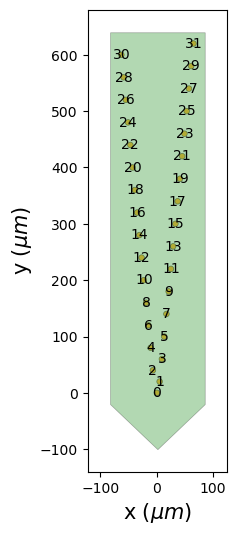

In [21]:
plot_probe_group(probe_object, same_axes=False, with_channel_index=True)
plt.show()

# Part 2: Preprocessing

- Preproccessing the signal to improve the spike sorting performance

- **NOTE**: If you want to add preprocessing steps, you must either make additional code cells to a similar format as below or change the `Raw NBConvert` cells into `Code` cells.
    - Here are more available steps: https://spikeinterface.readthedocs.io/en/latest/modules/preprocessing/plot_1_preprocessing.html#sphx-glr-modules-preprocessing-plot-1-preprocessing-py
- **NOTE**: If you want to remove preprocessing steps, you must turn unneeded `Code` cells into `Raw NBConvert` cells.
- **NOTE**: If you want to reorder the preprocessing steps, you must reorder the `Code` cells by clicking on the up or down arrow on the top menu when you have the `Code` cell clicked.

- All available preprocessing methods shown below:

In [22]:
for method in dir(st.preprocessing):
    print(method)


__builtins__
__cached__
__doc__
__file__
__loader__
__name__
__package__
__path__
__spec__


In [23]:
preprocessing_step_dict = defaultdict(dict)

In [24]:
preprocessing_step_dict["recording_raw"] = recording_raw

In [25]:
# To be used for all steps
recording_intermediate = spikeinterface.core.load_extractor(file_or_folder_or_dict=all_recording_raw_directories[0])

- Bandpass filter to only get the LFP

In [26]:
# Bandpass Filtering, keeping all the points that are within a certain frequency range
recording_bandpass = st.bandpass_filter(recording_intermediate, freq_min=1, freq_max=300)
recording_intermediate = st.bandpass_filter(recording_intermediate, freq_min=1, freq_max=300)
preprocessing_step_dict["recording_bandpass"] = recording_bandpass
print(recording_bandpass)

BandpassFilterRecording: 32 channels - 1 segments - 20.0kHz - 3205.690s


- Resampling to lower the number of samples

In [27]:
recording_raw.sampling_frequency

20000.0

In [28]:
resampled_frequency = 1000

In [29]:
original_to_resampled_frequency_ratio = resampled_frequency / recording_raw.sampling_frequency

In [30]:
original_to_resampled_frequency_ratio

0.05

In [31]:
# Bandpass Filtering, keeping all the points that are within a certain frequency range
recording_resample = st.resample(recording_intermediate, resampled_frequency)
recording_intermediate = st.resample(recording_intermediate, resampled_frequency)
preprocessing_step_dict["recording_resample"] = recording_resample
print(recording_resample)

ResampleRecording: 32 channels - 1 segments - 1.0kHz - 3205.690s


In [32]:
preprocessing_step_dict

defaultdict(dict,
            {'recording_raw': BinaryFolderRecording: 32 channels - 1 segments - 20.0kHz - 3205.690s,
             'recording_bandpass': BandpassFilterRecording: 32 channels - 1 segments - 20.0kHz - 3205.690s,
             'recording_resample': ResampleRecording: 32 channels - 1 segments - 1.0kHz - 3205.690s})

# Part 3: Visualization and EDA

## Plotting the Time Series

- Plotting with lines are better for recordings with smaller channel numbers

In [33]:
time_difference = 1

In [34]:
start_time = 500

In [35]:
time_range = [start_time, start_time + time_difference] 

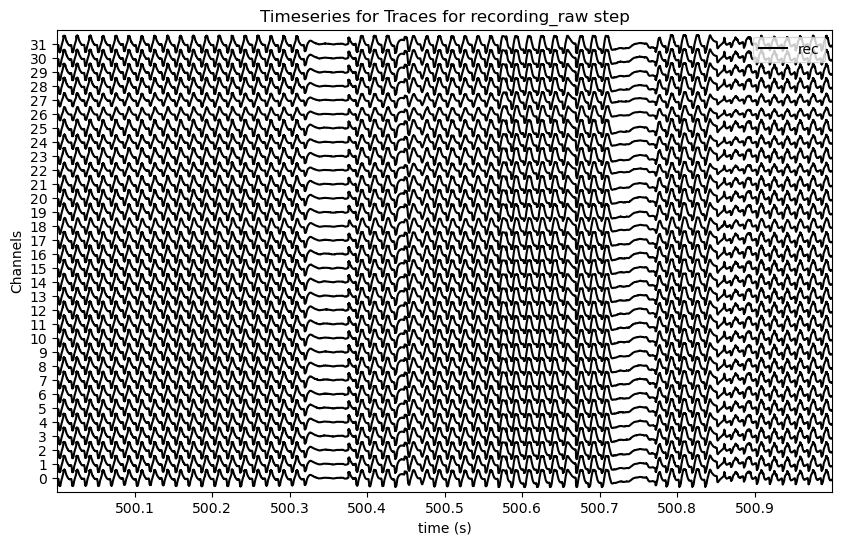

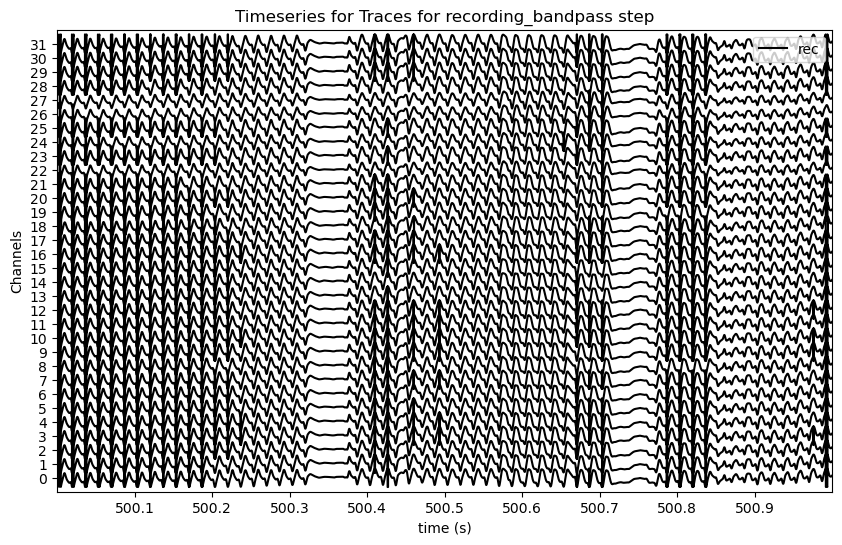

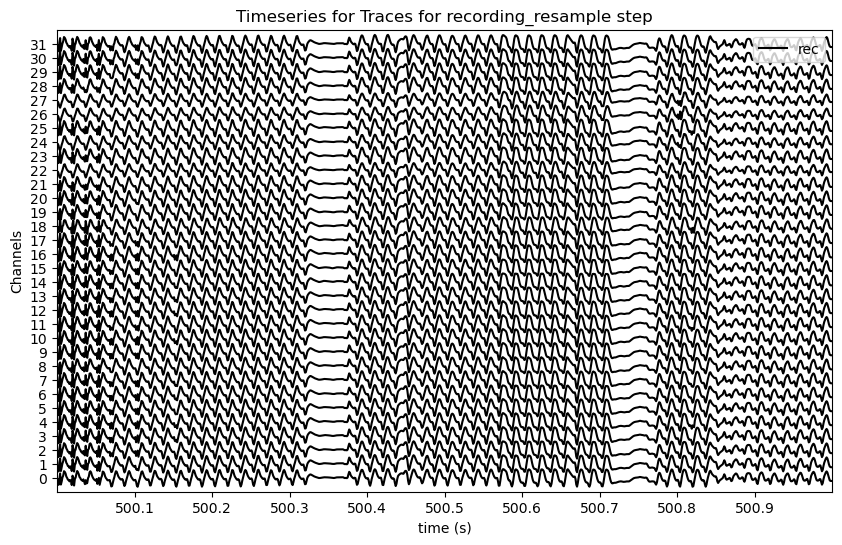

In [36]:
for key, value in preprocessing_step_dict.items():
    sw.plot_timeseries(value, time_range=(time_range[0], time_range[1]), show_channel_ids=True) #, figure=fig)
    plt.title("Timeseries for Traces for {} step".format(key))
    plt.ylabel("Channels")
    plt.show()

- Looking more closely at a few of the channels
    - The Channel IDs:

In [37]:
recording_intermediate.channel_ids

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31'], dtype='<U2')

In [38]:
channel_ids = np.random.choice(recording_intermediate.channel_ids, size=5, replace=False)

In [39]:
channel_ids = sorted(channel_ids, key=lambda x: float(x))

In [40]:
channel_ids

['2', '5', '13', '17', '18']

- If you want to use a specific set of channels, change the channels in the cell below and turn it into a `Code` cell

In [41]:
# Best channels with current setup
channel_ids = ["16", "21", "15", "14", "13"]

- With Raw Recording

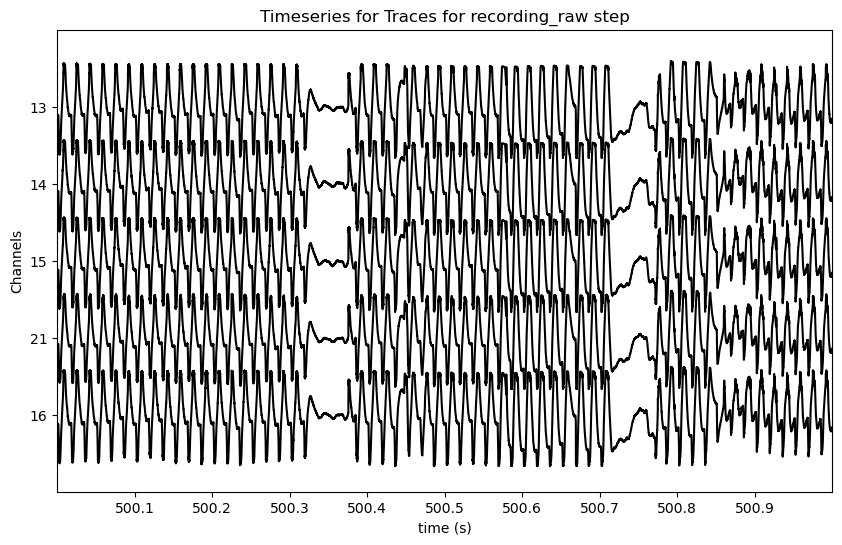

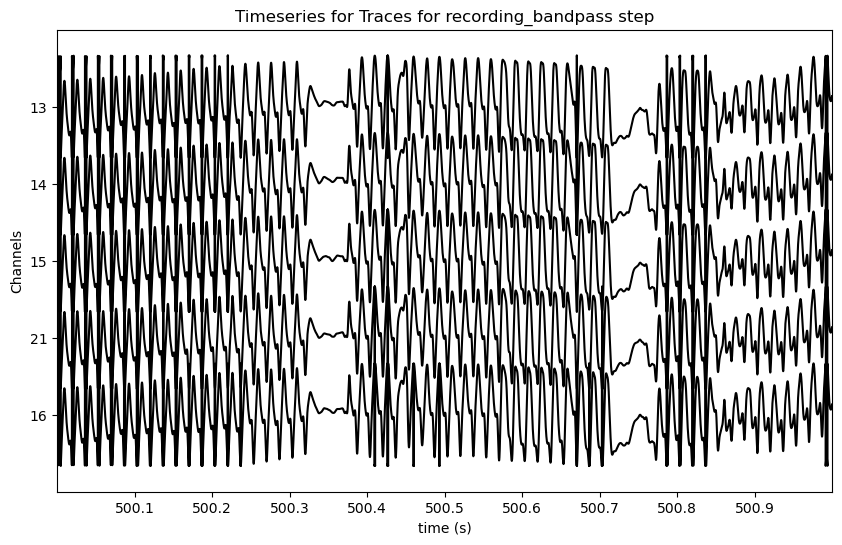

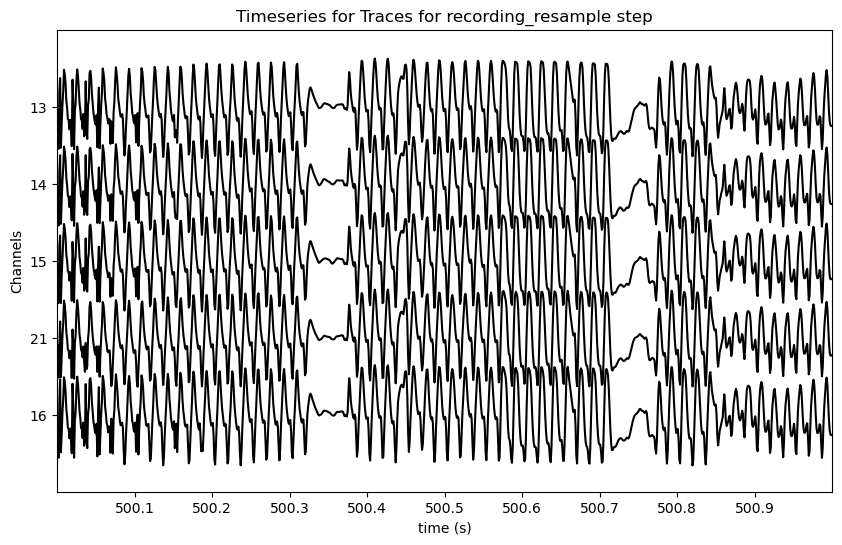

In [42]:
for key, value in preprocessing_step_dict.items():
    sw.plot_timeseries(value, time_range=time_range, channel_ids=channel_ids, show_channel_ids=True)
    plt.title("Timeseries for Traces for {} step".format(key))
    plt.ylabel("Channels")
    
    plt.legend().remove()
    plt.savefig("./proc/cmr_plot_{}.svg".format(key))
    plt.savefig("./proc/cmr_plot_{}.png".format(key))
    plt.show()

- Heat map is better for high channel counts

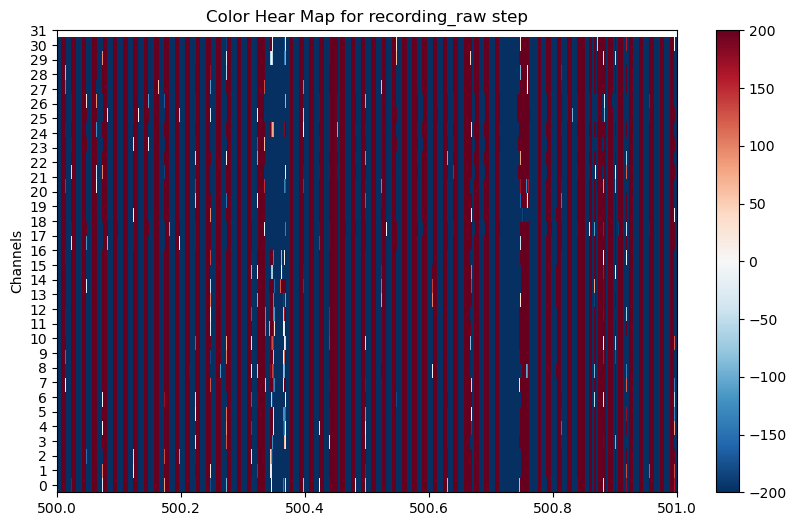

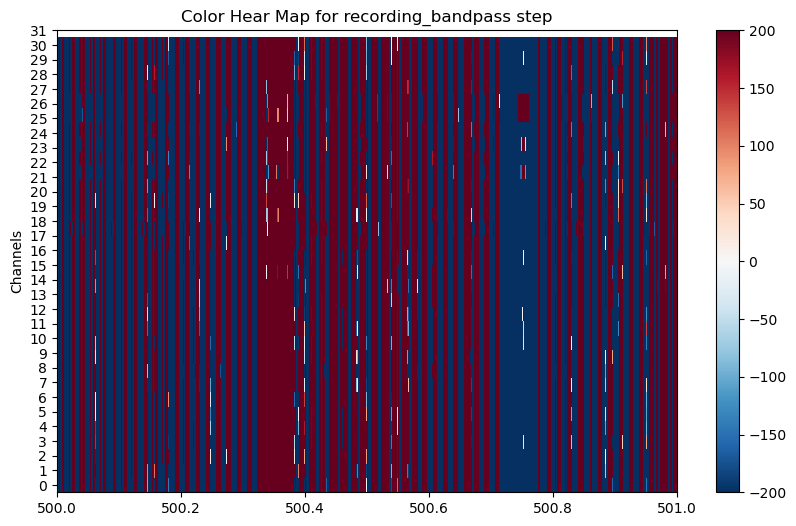

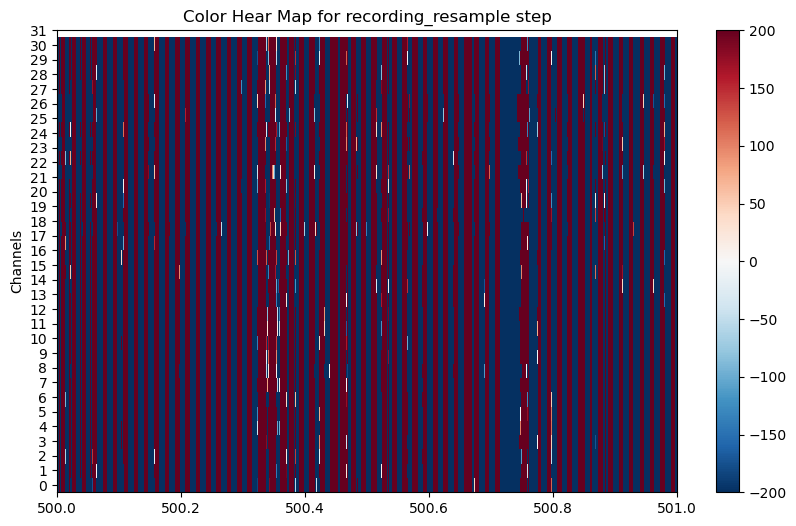

In [43]:
for key, value in preprocessing_step_dict.items():
    w_ts = sw.plot_timeseries(value, time_range=time_range, mode="map", show_channel_ids=True)
    plt.title("Color Hear Map for {} step".format(key))
    plt.ylabel("Channels")
    plt.show()


# Plotting the Power and Coherence

## Sync up the tone times with the LFP

## Starting off with mPFC channel

In [44]:
tone_label_df = pd.read_csv("./proc/subj_6_3_date_20221214_tone_label_df.csv", index_col=0)

In [45]:
tone_label_df["resampled_timestamps"] = (tone_label_df["tone_time_stamp"] * original_to_resampled_frequency_ratio).astype(int)

In [46]:
tone_label_df

tone_time_stamp tone_category  resampled_timestamps
0           1408048      rewarded                 70402
1           3008051      rewarded                150402
2           4808043      rewarded                240402
3           6408042      omission                320402
4           7908040      rewarded                395402
5           9908037      rewarded                495401
6          11808035      rewarded                590401
7          13608031      rewarded                680401
8          15208032      omission                760401
9          17008029      rewarded                850401
10         19008027      rewarded                950401
11         20808026      omission               1040401
12         23208023      rewarded               1160401
13         25008021      rewarded               1250401
14         27998597           win               1399929
15         29598593          lose               1479929
16         31398591          lose               1569929
17         32998593          lose               1649929
18         34498591          lose               1724929
19         36498588          lose               1824929
20         38398586          lose               1919929
21         40198584          lose               2009929
22         41798580          lose               2089929
23         43598581          lose               2179929
24         45598579          lose               2279928
25         47398577          lose               2369928
26         49798572           win               2489928
27         51598570           win               2579928
28         53298568           win               2664928
29         55098566           win               2754928
30         56998564          lose               2849928
31         59398564           win               2969928
32         60998563           win               3049928

## Plotting without editing

In [47]:
channel_id_to_brain_region

{'13': 'LH', '14': 'BLA', '15': 'vHPC', '21': 'mPFC', '16': 'MD'}

In [48]:
channel_id_to_brain_region.keys()

dict_keys(['13', '14', '15', '21', '16'])

In [49]:
time_stamp = tone_label_df["resampled_timestamps"][0]

In [50]:
time_stamp

70402

In [51]:
example_trace = recording_intermediate.get_traces(channel_ids=channel_id_to_brain_region.keys(), start_frame=time_stamp, end_frame=time_stamp+resampled_frequency*15)

In [52]:
example_trace = recording_intermediate.get_traces(channel_ids=recording_intermediate.channel_ids, start_frame=time_stamp, end_frame=time_stamp+resampled_frequency*15)

In [53]:
# Compute multitaper spectral estimate
m = Multitaper(time_series=example_trace)

# Sets up computing connectivity measures/power from multitaper spectral estimate
c = Connectivity.from_multitaper(m)

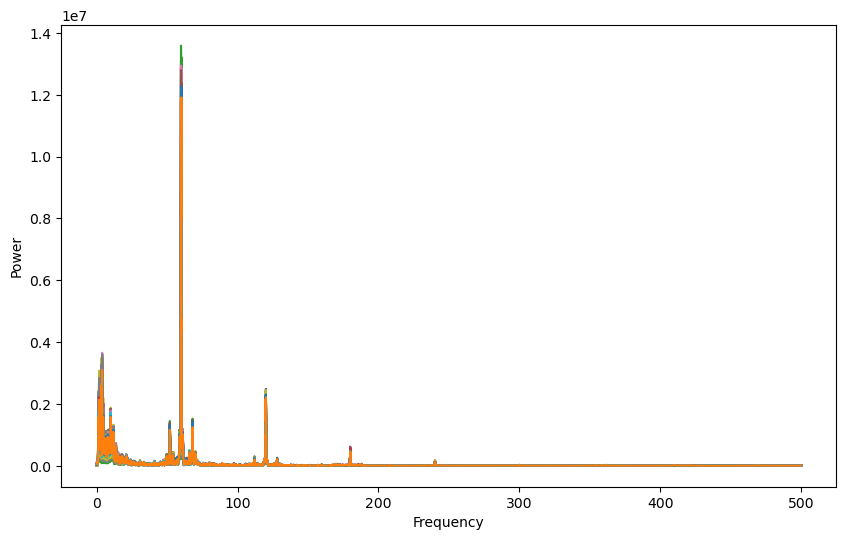

In [54]:
fig, ax = plt.subplots()
ax.set_xlabel("Frequency")
ax.set_ylabel("Power")
ax.plot(c.frequencies, c.power().squeeze())

(100000.0, 6000000.0)

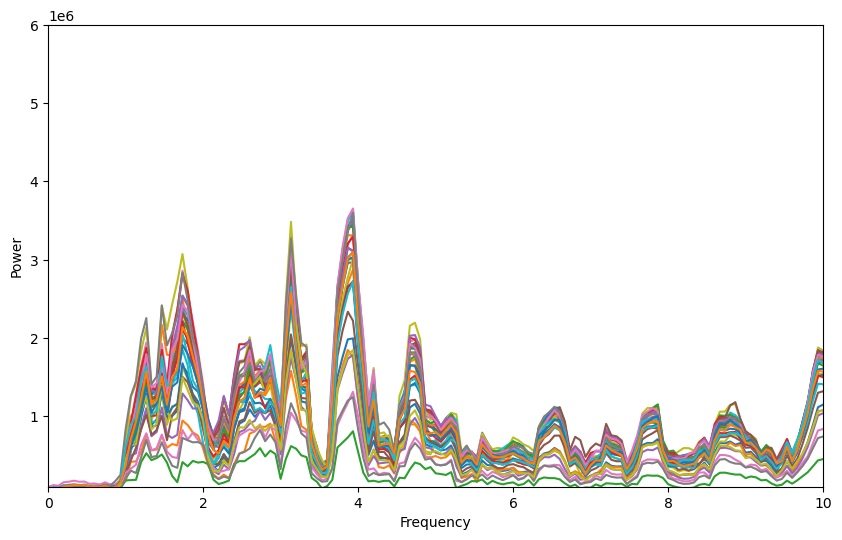

In [55]:
fig, ax = plt.subplots()
ax.set_xlabel("Frequency")
ax.set_ylabel("Power")
ax.plot(c.frequencies, c.power().squeeze())
ax.set_xlim(0,10)
ax.set_ylim(0.1*10**6, 0.6*10**7)

## Plotting with ICA

In [56]:
from sklearn.decomposition import FastICA, PCA

- 1. Creating 3 Independent Components
    - 1: Volume Conducted Noise
    - 2: Electrical Reference
    - 3: Local Activity

In [57]:
n_components = 3

In [58]:
example_trace = recording_intermediate.get_traces(channel_ids=recording_intermediate.channel_ids, start_frame=time_stamp, end_frame=time_stamp+resampled_frequency*15)

In [59]:
# Compute ICA
ica = FastICA(n_components=n_components, whiten="arbitrary-variance")
reconstructed_signal = ica.fit_transform(example_trace)  # Reconstruct signals
mixing_matrix = ica.mixing_  # Get estimated mixing matrix

- 2. Figure out which IC to keep

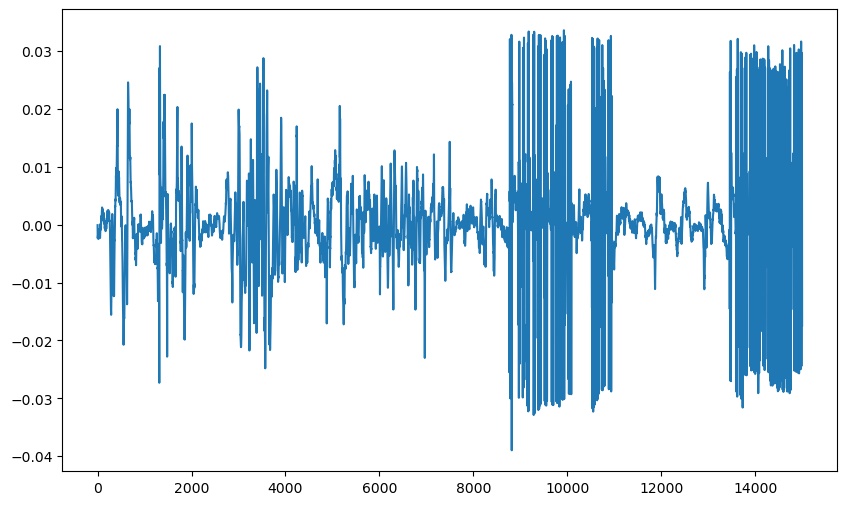

In [60]:
fig, ax = plt.subplots()
ax.plot(reconstructed_signal[:,0])
# ax.set_xlim(0,100)

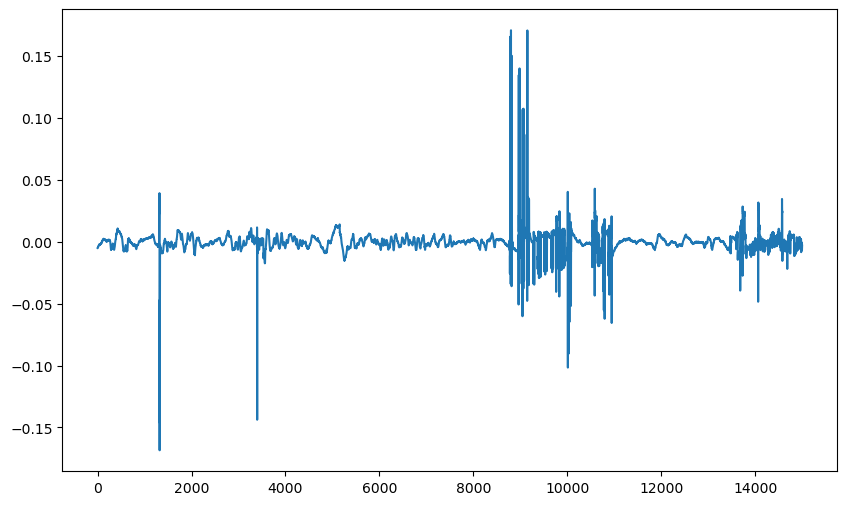

In [61]:
fig, ax = plt.subplots()
ax.plot(reconstructed_signal[:,1])

In [62]:
# Compute multitaper spectral estimate
m = Multitaper(time_series=reconstructed_signal)

# Sets up computing connectivity measures/power from multitaper spectral estimate
c = Connectivity.from_multitaper(m)

(0.0, 100.0)

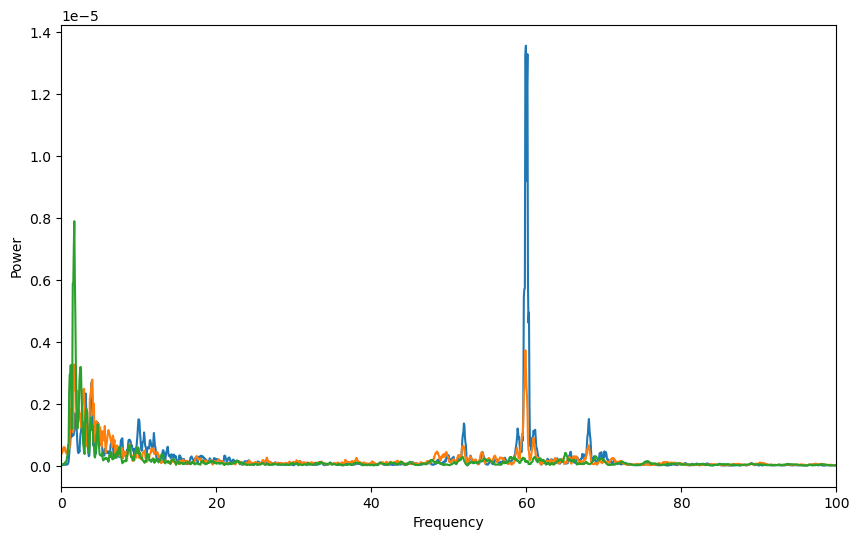

In [63]:
fig, ax = plt.subplots()
ax.set_xlabel("Frequency")
ax.set_ylabel("Power")
ax.plot(c.frequencies, c.power().squeeze())
ax.set_xlim(0,100)

- 2.5 Looking at each IC individually

Current Index: 0


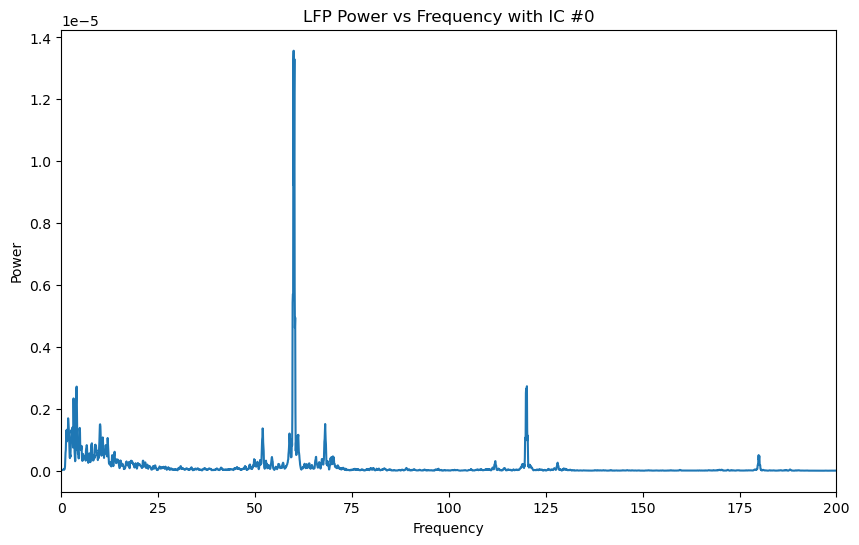

Current Index: 1


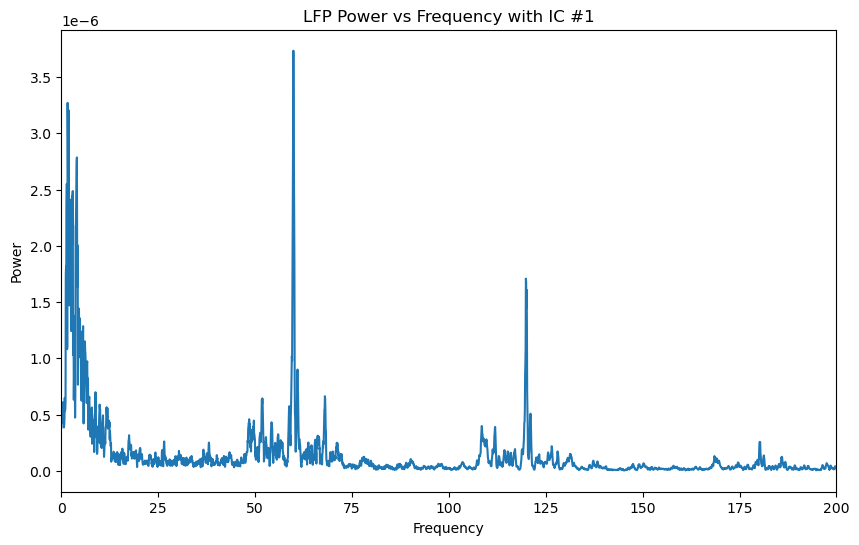

Current Index: 2


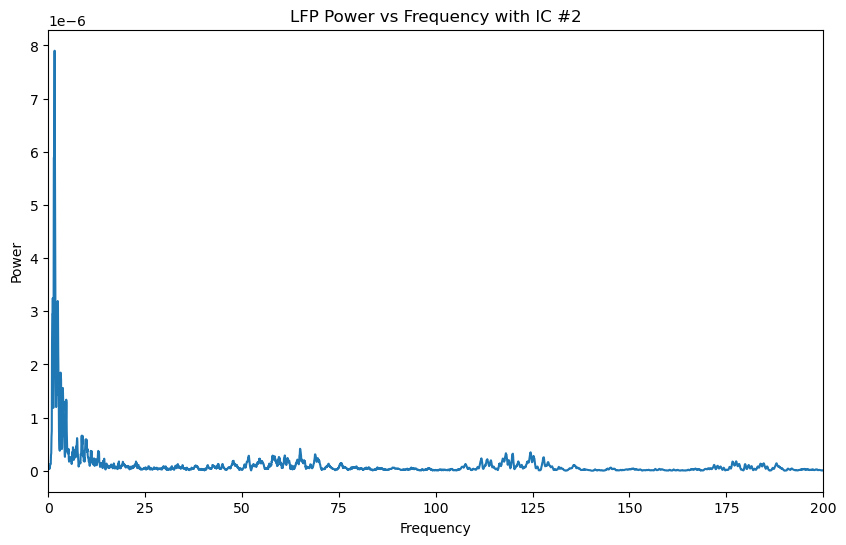

In [64]:
for index in range(n_components):
    print("Current Index: {}".format(index))
   
    m = Multitaper(time_series=reconstructed_signal[:, index])

    # Sets up computing connectivity measures/power from multitaper spectral estimate
    c = Connectivity.from_multitaper(m)
    
    fig, ax = plt.subplots()
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Power")
    ax.plot(c.frequencies, c.power().squeeze())
    ax.set_xlim(0,200)
    plt.title("LFP Power vs Frequency with IC #{}".format(index))
    plt.show()

## Reconstructing the recording and plotting

In [65]:
reconstructed_signal[:,0] = 0
reconstructed_signal[:,1] = 0

In [66]:
reconstructed_signal = np.dot(reconstructed_signal, mixing_matrix.T) + ica.mean_

In [67]:
# Compute multitaper spectral estimate
m = Multitaper(time_series=reconstructed_signal)

# Sets up computing connectivity measures/power from multitaper spectral estimate
c = Connectivity.from_multitaper(m)

In [68]:
brain_region_channels = list(sorted(channel_id_to_brain_region.keys()))

In [69]:
brain_region_channels = [int(num) for num in brain_region_channels]

(0.0, 10.0)

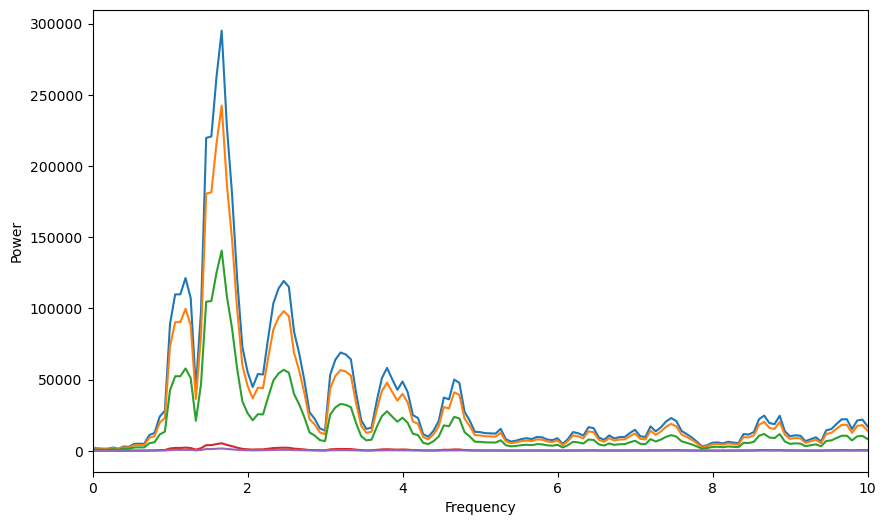

In [70]:
fig, ax = plt.subplots()
ax.set_xlabel("Frequency")
ax.set_ylabel("Power")
ax.plot(c.frequencies, c.power().squeeze()[:, brain_region_channels])
ax.set_xlim(0,10)


In [71]:
reconstructed_signal

array([[-102.51674446, -249.24806371, -278.1788503 , ..., -200.88457739,
          26.44494078,  -42.2862851 ],
       [ -92.34855989, -221.50511302, -241.95523923, ..., -176.82310769,
          20.15291633,  -40.68604783],
       [ -76.68276054, -178.76242912, -186.14667096, ..., -139.75236474,
          10.4589939 ,  -38.22061303],
       ...,
       [  -2.88772746,   22.58049009,   76.74416855, ...,   34.87241129,
         -35.20502303,  -26.60698016],
       [  14.02642766,   68.7291972 ,  136.99993718, ...,   74.89719923,
         -45.6714221 ,  -23.94508301],
       [  25.58971627,  100.27856017,  178.19353142, ...,  102.25997148,
         -52.82673032,  -22.1252886 ]])

# Plotting and comparing different trial types

In [72]:
brain_region_channels = list(sorted(channel_id_to_brain_region.keys()))

In [73]:
brain_region_channels

['13', '14', '15', '16', '21']

- Getting the number of frames for reference
    - Just put a high enough number and you'll gett all the traces

In [74]:
recording_shape = recording_intermediate.get_traces(channel_ids=["1"], start_frame=0, end_frame=100000000000).shape

In [75]:
recording_shape

(3205691, 1)

In [76]:
all_traces = recording_intermediate.get_traces(channel_ids=brain_region_channels, start_frame=0, end_frame=recording_shape[0] * 1.5)

In [77]:
all_traces.shape

(3205691, 5)

- Getting the ICA for all the channels

In [78]:
n_components = 3

In [79]:
# Compute ICA
ica_object = FastICA(n_components=n_components, whiten="arbitrary-variance")
ica_array = ica_object.fit_transform(all_traces)  # Reconstruct signals
mixing_matrix = ica_object.mixing_  # Get estimated mixing matrix

- Finding out which ICA is noise

- 2.5 Looking at each IC individually

In [80]:
reconstructed_signal[:, index]

array([-278.1788503 , -241.95523923, -186.14667096, ...,   76.74416855,
        136.99993718,  178.19353142])

Current Index: 0


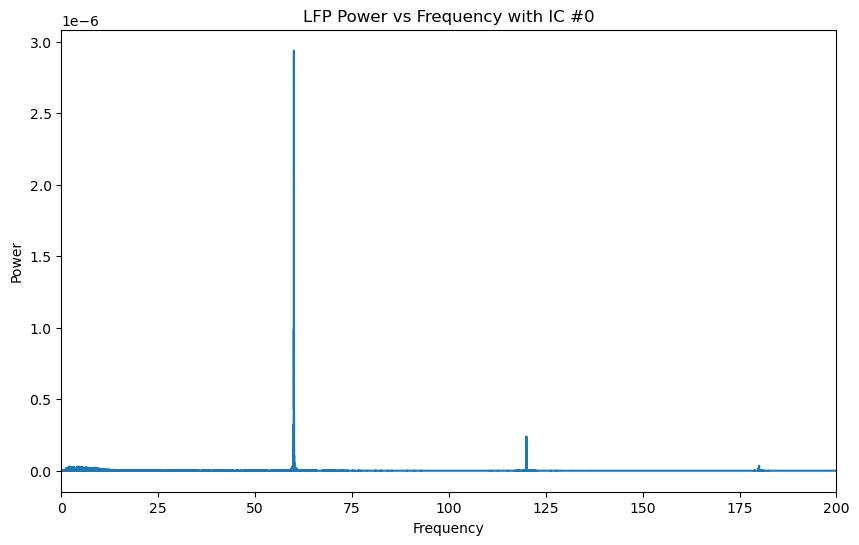

Current Index: 1


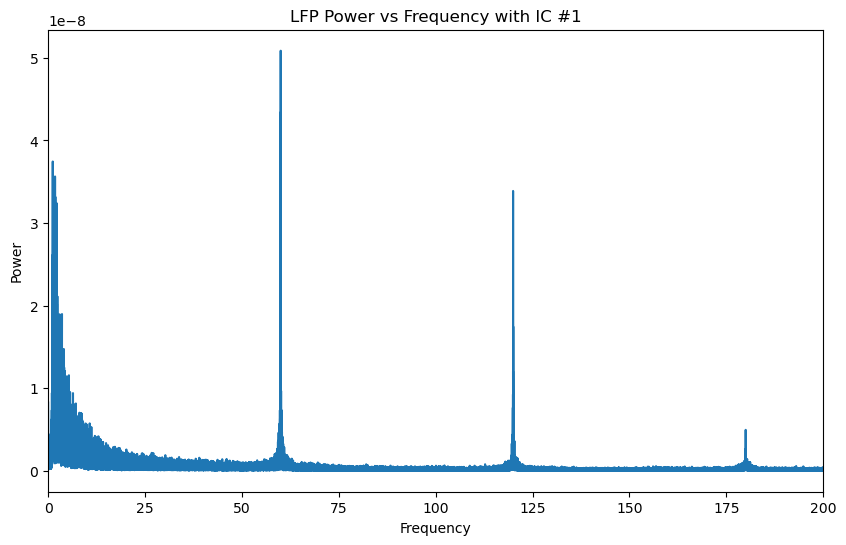

Current Index: 2


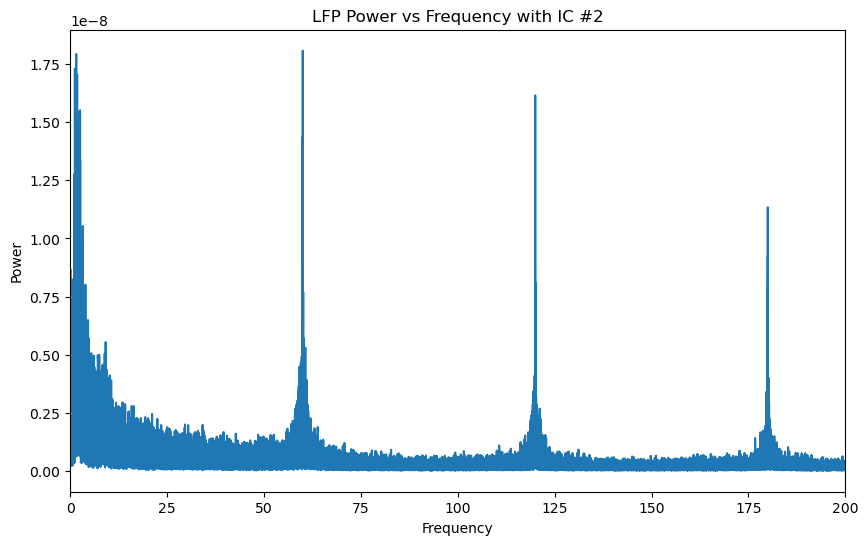

In [81]:
index_to_multitaper = {}
index_to_connectivity = {}

for index in range(n_components):
    print("Current Index: {}".format(index))
   
    index_to_multitaper[index] = Multitaper(time_series=ica_array[:, index])

    # Sets up computing connectivity measures/power from multitaper spectral estimate
    index_to_connectivity[index] = Connectivity.from_multitaper(index_to_multitaper[index])
    
    fig, ax = plt.subplots()
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Power")
    ax.plot(index_to_connectivity[index].frequencies, index_to_connectivity[index].power().squeeze())
    ax.set_xlim(0,200)
    plt.title("LFP Power vs Frequency with IC #{}".format(index))
    plt.show()

In [82]:
index_to_connectivity[index].power().squeeze()[0]

7.596556901330152e-09

In [83]:
7.8*10**-9


7.8e-09

Current Index: 0


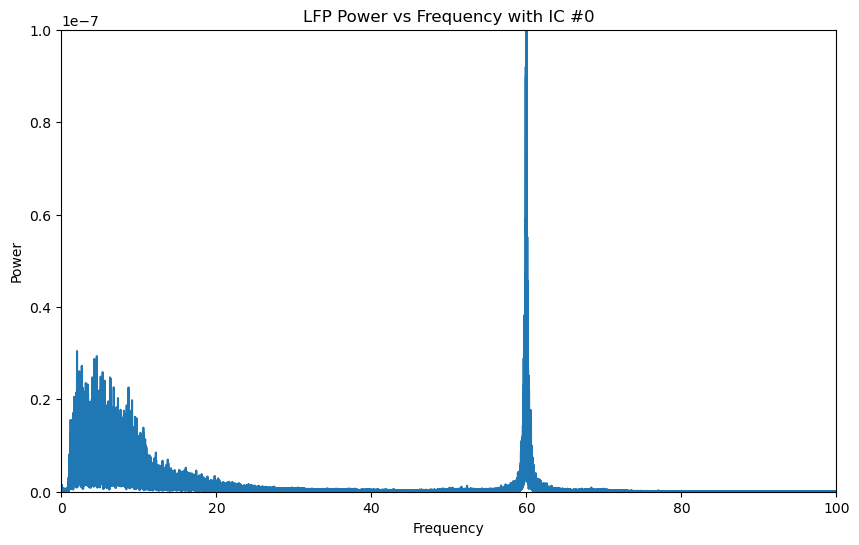

Current Index: 1


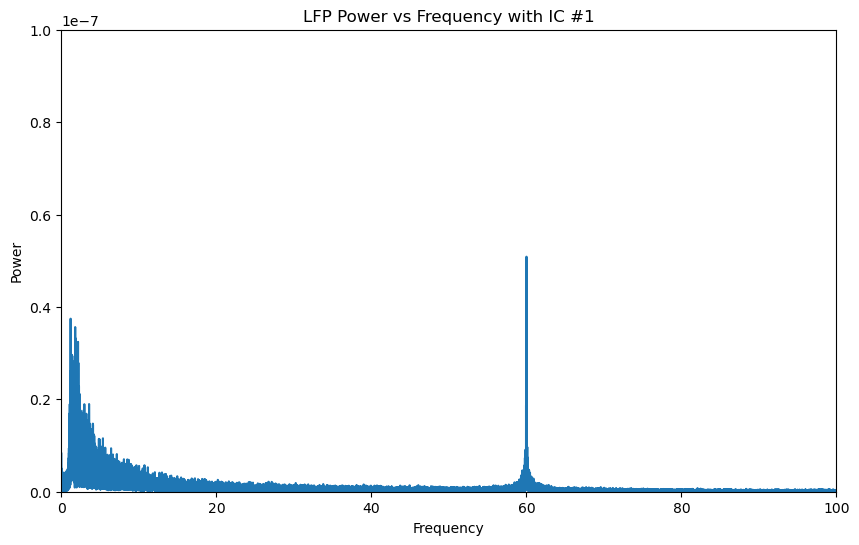

Current Index: 2


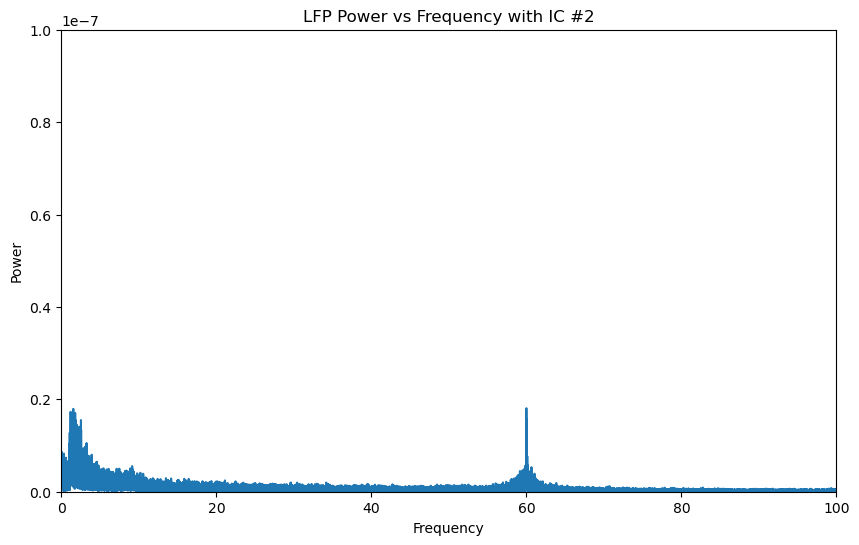

In [84]:
for index in range(n_components):
    print("Current Index: {}".format(index))
    
    fig, ax = plt.subplots()
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Power")
    ax.plot(index_to_connectivity[index].frequencies, index_to_connectivity[index].power().squeeze())
    ax.set_xlim(0,100)
    ax.set_ylim(0,1*10**-7)

    plt.title("LFP Power vs Frequency with IC #{}".format(index))
    plt.show()

- Reconstructing the signal

In [142]:
ica_array_copy = ica_array.copy()

In [143]:
ica_array_copy[:,0] = 0
ica_array_copy[:,1] = 0

In [144]:
mixing_matrix.T

array([[-19315251.92817047, -19309405.69892756, -19203050.80676401,
        -19670624.71136862, -18517002.75531495],
       [  2460428.16782981,   1714285.37406028,   1236258.64758174,
          1687176.07297907,  -2098346.92712463],
       [  1493645.52246389,   2187185.86837355,   2569160.20766781,
         -1931410.36721988,    170734.07449725]])

In [145]:
reconstructed_signal = np.dot(ica_array_copy, mixing_matrix.T) + ica_object.mean_

In [146]:
reconstructed_signal.shape

(3205691, 5)

In [147]:
reconstructed_signal

array([[ 634.5339854 ,  890.42471598, 1042.65835758, -696.8158904 ,
          89.6513882 ],
       [ 702.28450135,  989.63364395, 1159.19332321, -784.42305483,
          97.39574352],
       [ 735.13931279, 1037.74384024, 1215.70557655, -826.9071131 ,
         101.15127703],
       ...,
       [ 175.82945868,  218.7311692 ,  253.65896019, -103.67202522,
          37.2182696 ],
       [ 163.92686529,  201.30187713,  233.18578309,  -88.28096226,
          35.85772037],
       [ 159.71823183,  195.13906039,  225.9466802 ,  -82.83884217,
          35.37664428]])

## Making plots for all brain regions

In [148]:
brain_region_channels

['13', '14', '15', '16', '21']

In [149]:
channel_id_to_brain_region

{'13': 'LH', '14': 'BLA', '15': 'vHPC', '21': 'mPFC', '16': 'MD'}

In [150]:
index_to_brain_region = {}
for index, channel in enumerate(brain_region_channels):
    index_to_brain_region[index] = channel_id_to_brain_region[channel]

In [151]:
index_to_brain_region

{0: 'LH', 1: 'BLA', 2: 'vHPC', 3: 'MD', 4: 'mPFC'}

In [152]:
tone_label_df.head()

tone_time_stamp tone_category  resampled_timestamps
0          1408048      rewarded                 70402
1          3008051      rewarded                150402
2          4808043      rewarded                240402
3          6408042      omission                320402
4          7908040      rewarded                395402

- Getting the timestamps for each trial

In [153]:
tone_label_to_timestamps = {}
for tone_label in tone_label_df["tone_category"].unique():
        tone_label_to_timestamps[tone_label] = tone_label_df[tone_label_df["tone_category"] == tone_label]["resampled_timestamps"]

In [154]:
tone_label_to_timestamps

{'rewarded': 0       70402
 1      150402
 2      240402
 4      395402
 5      495401
 6      590401
 7      680401
 9      850401
 10     950401
 12    1160401
 13    1250401
 Name: resampled_timestamps, dtype: int64,
 'omission': 3      320402
 8      760401
 11    1040401
 Name: resampled_timestamps, dtype: int64,
 'win': 14    1399929
 26    2489928
 27    2579928
 28    2664928
 29    2754928
 31    2969928
 32    3049928
 Name: resampled_timestamps, dtype: int64,
 'lose': 15    1479929
 16    1569929
 17    1649929
 18    1724929
 19    1824929
 20    1919929
 21    2009929
 22    2089929
 23    2179929
 24    2279928
 25    2369928
 30    2849928
 Name: resampled_timestamps, dtype: int64}

- Getting the traces and relevant stats for during the trial

In [155]:
reconstructed_signal.shape

(3205691, 5)

In [156]:
reconstructed_signal[time_stamp:time_stamp+resampled_frequency*duration, 0]

array([-40.21530094, -38.08137278,  32.96378323, ...,  -6.41459696,
        22.34335934,  -0.48134792])

In [157]:
reconstructed_signal[time_stamp:time_stamp+resampled_frequency*duration, 4]

array([12.52285055, 12.76677338, 20.88772898, ..., 16.38650617,
       19.67374064, 17.06471781])

In [158]:
duration = 15

brain_region_to_during_tone_label_to_traces = defaultdict(dict)
for index, brain_region in index_to_brain_region.items():
    print("Index: {}".format(index))
    brain_region_to_during_tone_label_to_traces[brain_region] = defaultdict(dict)
    for tone_label in tone_label_df["tone_category"].unique():
        print(tone_label)
                
        brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["power_list"] = []
        brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["frequency_list"] = []

        for time_stamp in tone_label_to_timestamps[tone_label]:
            recording_traces = reconstructed_signal[time_stamp:time_stamp+resampled_frequency*duration, index]

            # Making sure everything is same number
            recording_traces = recording_traces[:resampled_frequency*duration]        
            # Compute multitaper spectral estimate
            m = Multitaper(time_series=recording_traces, sampling_frequency=resampled_frequency)
            # Sets up computing connectivity measures/power from multitaper spectral estimate
            c = Connectivity.from_multitaper(m)
            brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["power_list"].append(c.power().squeeze())
            brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["frequency_list"].append(c.frequencies)
            # To see if everything is shaped correctly
            print(c.power().squeeze().shape)
            print(c.frequencies.shape)

        brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["traces_array"] = np.vstack(brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["power_list"])
        brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"] = np.mean(brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["traces_array"], axis = 0)
        brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["ste_traces_array"] = stats.sem(brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["traces_array"])


Index: 0
rewarded
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
omission
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
win
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
lose
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
Index: 1
rewarded
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
omission
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
win
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
lose
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)


- Getting the traces and relevant stats for before the trial

In [159]:
index_to_brain_region

{0: 'LH', 1: 'BLA', 2: 'vHPC', 3: 'MD', 4: 'mPFC'}

In [160]:
duration = 15

brain_region_to_before_tone_label_to_traces = defaultdict(dict)
for index, brain_region in index_to_brain_region.items():
    print("Index: {}".format(index))
    brain_region_to_before_tone_label_to_traces[brain_region] = defaultdict(dict)
    for tone_label in tone_label_df["tone_category"].unique():
        print(tone_label)
                
        brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["power_list"] = []
        brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["frequency_list"] = []

        for time_stamp in tone_label_to_timestamps[tone_label]:
            recording_traces = reconstructed_signal[time_stamp-resampled_frequency*duration:time_stamp, index]

            # Making sure everything is same number
            recording_traces = recording_traces[:resampled_frequency*duration]        
            # Compute multitaper spectral estimate
            m = Multitaper(time_series=recording_traces, sampling_frequency=resampled_frequency)
            # Sets up computing connectivity measures/power from multitaper spectral estimate
            c = Connectivity.from_multitaper(m)
            brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["power_list"].append(c.power().squeeze())
            brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["frequency_list"].append(c.frequencies)
            # To see if everything is shaped correctly
            print(c.power().squeeze().shape)
            print(c.frequencies.shape)

        brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["traces_array"] = np.vstack(brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["power_list"])
        brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"] = np.mean(brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["traces_array"], axis = 0)
        brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["ste_traces_array"] = stats.sem(brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["traces_array"])


Index: 0
rewarded
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
omission
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
win
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
lose
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
Index: 1
rewarded
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
omission
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
win
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
lose
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)


In [161]:
brain_region_to_during_tone_label_to_traces

defaultdict(dict,
            {'LH': defaultdict(dict,
                         {'rewarded': {'power_list': [array([ 568.9117817 ,  920.66055513, 1124.49538518, ...,   76.85975968,
                                    140.06715758,  133.88417431]),
                            array([3003.06085352, 3028.17154743, 2289.78117223, ...,  163.94559895,
                                    167.46099873,  184.47284349]),
                            array([246.39179405, 200.28977766, 194.67373562, ...,  42.99306285,
                                    42.94970795,  42.84766569]),
                            array([5.99340519e+00, 6.11909806e+00, 6.60504789e+00, ...,
                                   4.15360502e-05, 3.58894296e-05, 4.65189525e-05]),
                            array([4.40163076e+02, 4.26506855e+02, 4.55087715e+02, ...,
                                   1.95317877e-02, 1.10815884e-02, 6.22191481e-03]),
                            array([3.51361138e-01, 3.53385562e-01, 3.69790562e

In [162]:
tone_label_to_timestamps

{'rewarded': 0       70402
 1      150402
 2      240402
 4      395402
 5      495401
 6      590401
 7      680401
 9      850401
 10     950401
 12    1160401
 13    1250401
 Name: resampled_timestamps, dtype: int64,
 'omission': 3      320402
 8      760401
 11    1040401
 Name: resampled_timestamps, dtype: int64,
 'win': 14    1399929
 26    2489928
 27    2579928
 28    2664928
 29    2754928
 31    2969928
 32    3049928
 Name: resampled_timestamps, dtype: int64,
 'lose': 15    1479929
 16    1569929
 17    1649929
 18    1724929
 19    1824929
 20    1919929
 21    2009929
 22    2089929
 23    2179929
 24    2279928
 25    2369928
 30    2849928
 Name: resampled_timestamps, dtype: int64}

In [163]:
tone_label_to_timestamps[tone_label]

15    1479929
16    1569929
17    1649929
18    1724929
19    1824929
20    1919929
21    2009929
22    2089929
23    2179929
24    2279928
25    2369928
30    2849928
Name: resampled_timestamps, dtype: int64

In [164]:
trials_with_reward = ['rewarded', 'win']

In [165]:
trials_without_reward = ['omission', 'lose']

LH
rewarded
[2967.13208976 3273.70400072 2670.54495363 3041.57331588 2707.31821645]
win
[1934.78192419 1536.5143656  1658.35966552 1677.51796672 1606.0964485 ]
BLA
rewarded
[6362.2858904  7019.65404406 5726.32763362 6521.90681334 5805.17886238]
win
[4148.66455719 3294.67761224 3555.94492661 3597.0251973  3443.87929616]
vHPC
rewarded
[8778.57798492 9685.60380884 7901.09318646 8998.82032301 8009.89082191]
win
[5724.25948409 4545.94226862 4906.43463468 4963.1165201  4751.80831117]
MD
rewarded
[4961.24774309 5473.85694125 4465.33377121 5085.71856338 4526.82118116]
win
[3235.08767537 2569.15708434 2772.89075745 2804.92474708 2685.50308488]
mPFC
rewarded
[38.76878649 42.77447973 34.89355512 39.74144154 35.37403753]
win
[25.28001621 20.07622026 21.66826075 21.91858465 20.98538535]


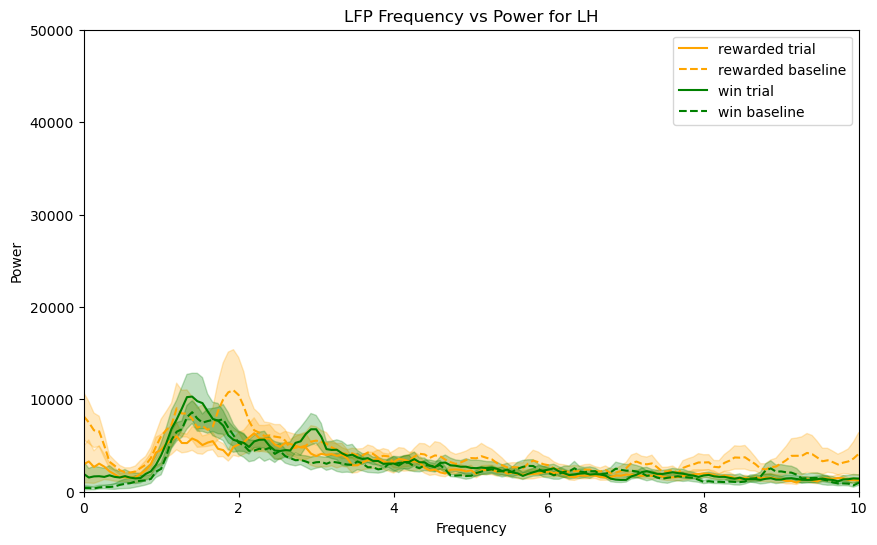

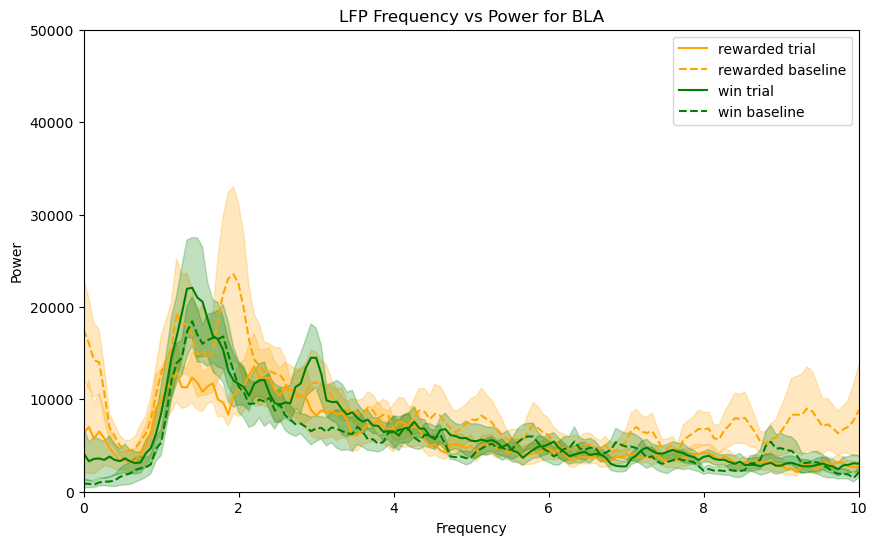

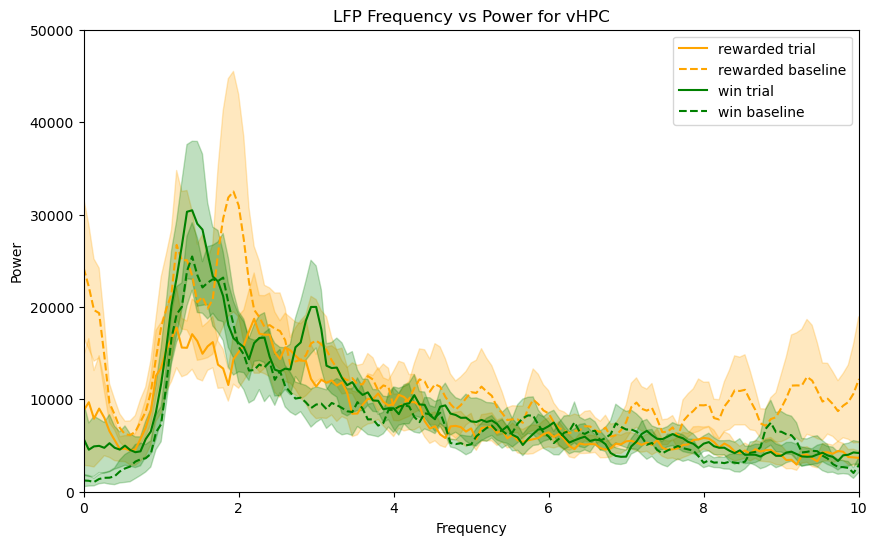

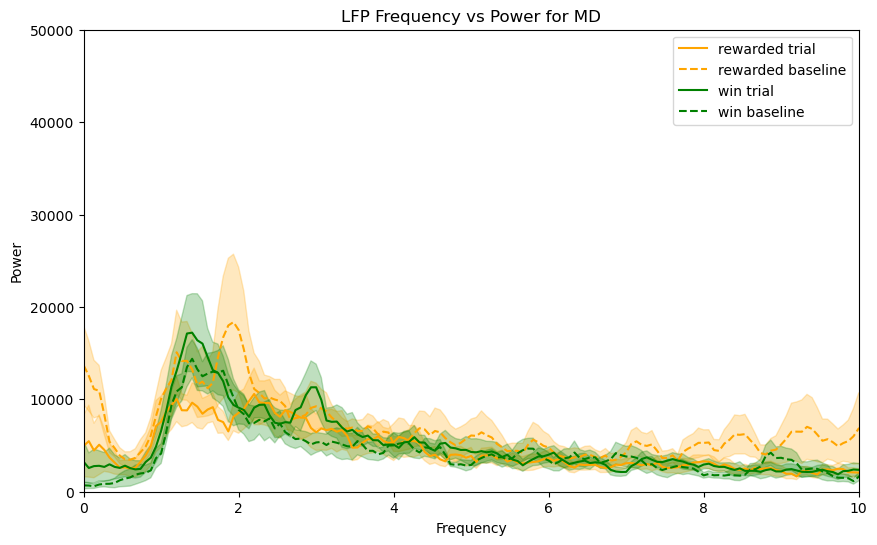

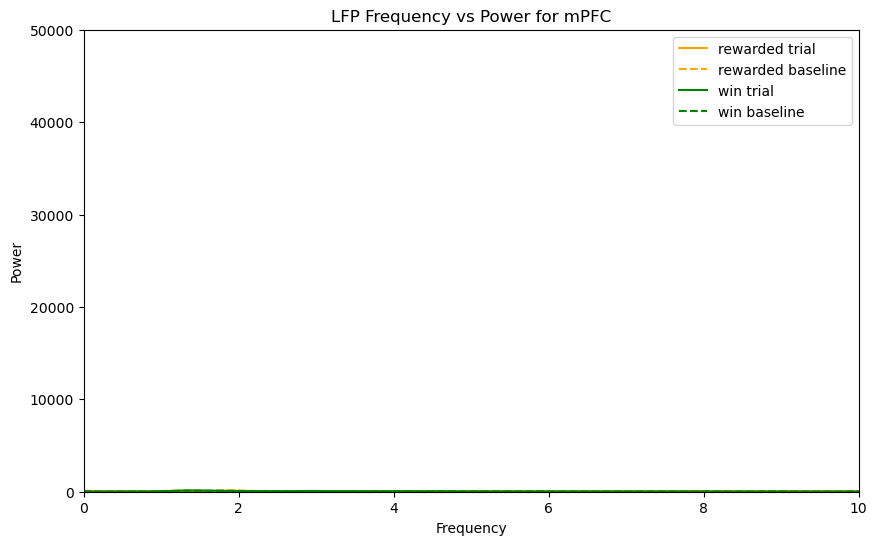

In [169]:
for brain_region, during_tone_label_to_traces in brain_region_to_during_tone_label_to_traces.items():
    print(brain_region)
    fig, ax = plt.subplots()
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Power")

    for tone_label in trials_with_reward:
        print(tone_label)
        print(brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"][:5])
        ax.plot(c.frequencies, brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"], label="{} trial".format(tone_label), linestyle="-", color=trial_type_to_color[tone_label])
        ax.fill_between(c.frequencies, brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"]-brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["ste_traces_array"], \
                            brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"]+brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["ste_traces_array"], \
                           alpha=.25, color=trial_type_to_color[tone_label])

        ax.plot(c.frequencies, brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"], label="{} baseline".format(tone_label), linestyle="--", color=trial_type_to_color[tone_label])
        ax.fill_between(c.frequencies, brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"]-brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["ste_traces_array"], \
                            brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"]+brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["ste_traces_array"], \
                           alpha=.25, color=trial_type_to_color[tone_label])

    ax.set_xlim(0,10)
#     ax.set_yscale("log")
    ax.set_ylim(0,50000)
    ax.legend()
    ax.set_title("LFP Frequency vs Power for {}".format(brain_region))

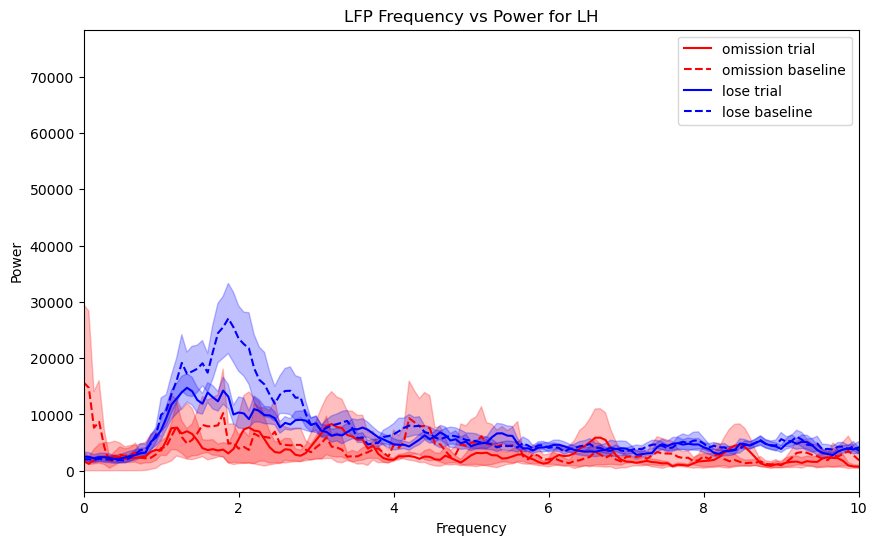

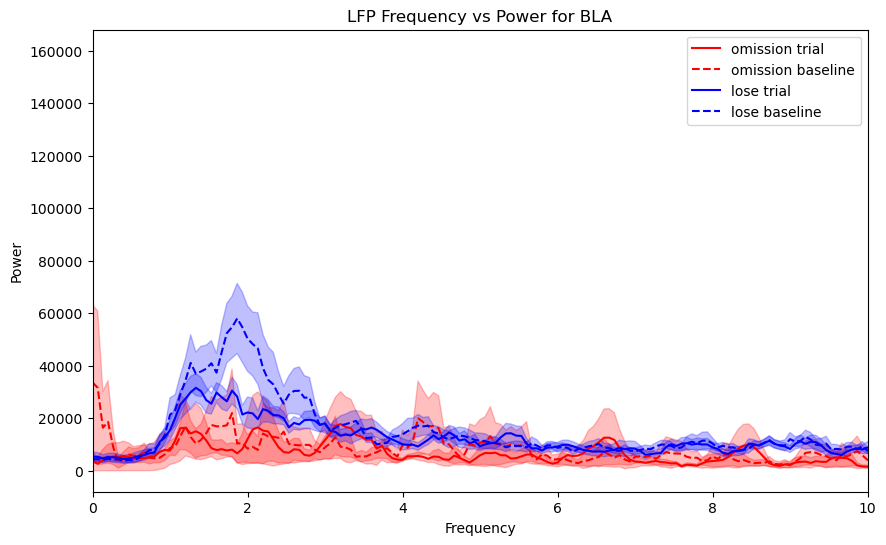

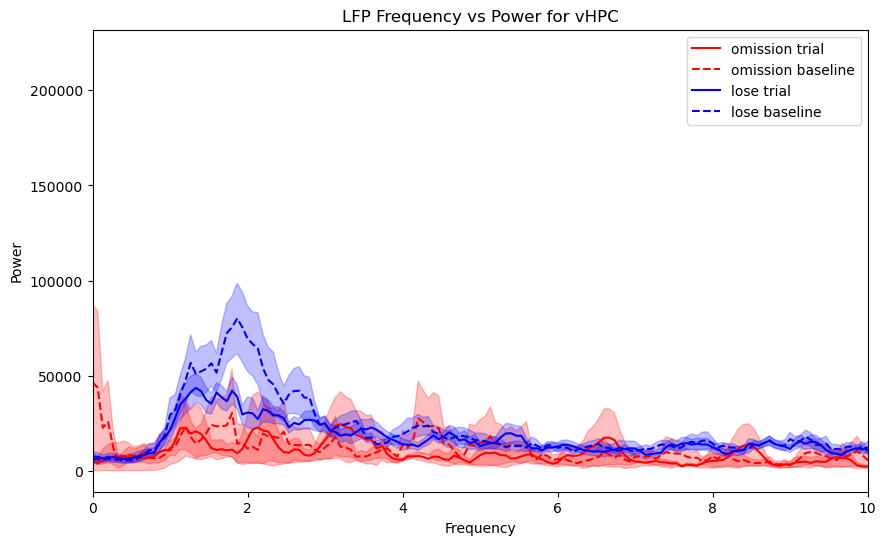

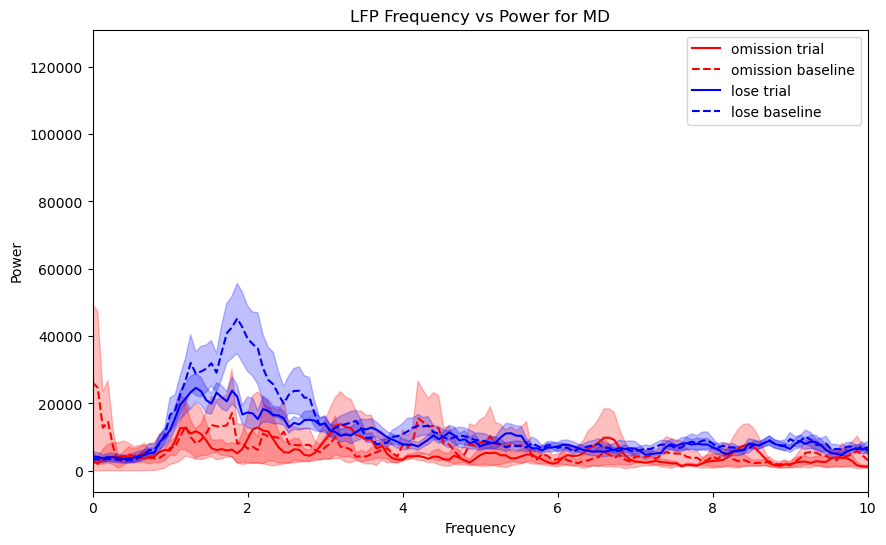

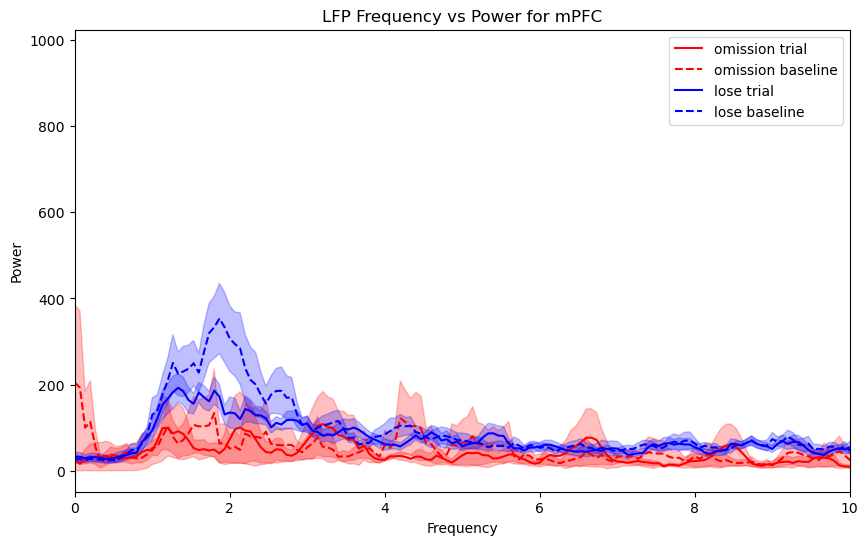

In [168]:
for brain_region, during_tone_label_to_traces in brain_region_to_during_tone_label_to_traces.items():
    fig, ax = plt.subplots()
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Power")

    for tone_label in trials_without_reward:


        ax.plot(c.frequencies, brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"], label="{} trial".format(tone_label), linestyle="-", color=trial_type_to_color[tone_label])
        ax.fill_between(c.frequencies, brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"]-brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["ste_traces_array"], \
                            brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"]+brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["ste_traces_array"], \
                           alpha=.25, color=trial_type_to_color[tone_label])

        ax.plot(c.frequencies, brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"], label="{} baseline".format(tone_label), linestyle="--", color=trial_type_to_color[tone_label])
        ax.fill_between(c.frequencies, brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"]-brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["ste_traces_array"], \
                            brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"]+brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["ste_traces_array"], \
                           alpha=.25, color=trial_type_to_color[tone_label])

    ax.set_xlim(0,10)
    # ax.set_yscale("log")
#     ax.set_ylim(0,40000)
    ax.legend()
    ax.set_title("LFP Frequency vs Power for {}".format(brain_region))

## Adding curving to the line

In [ ]:
from scipy.interpolate import make_interp_spline, BSpline


In [ ]:
from scipy.interpolate import make_interp_spline

In [ ]:
def get_smoothed_x_and_y(x_array, y_array, number_of_points=None):
    """
    """
    if number_of_points is None:
        number_of_points = len(x_array) // 10
    # 300 represents number of points to make between T.min and T.max
    xnew = np.linspace(x_array.min(), x_array.max(), number_of_points) 

    spl = make_interp_spline(x_array, y_array, k=3)  # type: BSpline
    return xnew, spl(xnew)

In [ ]:
number_of_points = 3750

In [ ]:
number_of_points = 750

In [ ]:
for brain_region, during_tone_label_to_traces in brain_region_to_during_tone_label_to_traces.items():
    print(brain_region)
    fig, ax = plt.subplots()
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Power")

    for tone_label in trials_with_reward:
        print(tone_label)
        smoothed_x_for_mean, smoothed_y_for_mean = get_smoothed_x_and_y(c.frequencies, \
            brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"],
            number_of_points)        
        smoothed_x_for_ste, smoothed_y_for_ste = get_smoothed_x_and_y(c.frequencies, \
            brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["ste_traces_array"],
            number_of_points)
        
        ax.plot(smoothed_x_for_mean, smoothed_y_for_mean, label="{} trial".format(tone_label), linestyle="-", color=trial_type_to_color[tone_label])
        ax.fill_between(smoothed_x_for_ste, smoothed_y_for_mean-smoothed_y_for_ste, \
                            smoothed_y_for_mean+smoothed_y_for_ste, \
                           alpha=.25, color=trial_type_to_color[tone_label])

        smoothed_x_for_mean, smoothed_y_for_mean = get_smoothed_x_and_y(c.frequencies, \
            brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"],
            number_of_points)        
        smoothed_x_for_ste, smoothed_y_for_ste = get_smoothed_x_and_y(c.frequencies, \
            brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["ste_traces_array"],
            number_of_points)
        
        ax.plot(smoothed_x_for_mean, smoothed_y_for_mean, label="{} baseline".format(tone_label), linestyle="--", color=trial_type_to_color[tone_label])
        ax.fill_between(smoothed_x_for_ste, smoothed_y_for_mean-smoothed_y_for_ste, \
                            smoothed_y_for_mean+smoothed_y_for_ste, \
                           alpha=.25, color=trial_type_to_color[tone_label])

    ax.set_xlim(0,10)
#     ax.set_yscale("log")
#     ax.set_ylim(0,40000)
    ax.legend()
    ax.set_title("LFP Frequency vs Power for {} for Subject {}".format(brain_region, subject_id))
    plt.savefig("lfp_{}_{}_20221214_rewarded.png".format(subject_id, brain_region))

In [ ]:
trials_without_reward

In [ ]:
for brain_region, during_tone_label_to_traces in brain_region_to_during_tone_label_to_traces.items():
    print(brain_region)
    fig, ax = plt.subplots()
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Power")

    for tone_label in trials_without_reward:
        print(tone_label)
        smoothed_x_for_mean, smoothed_y_for_mean = get_smoothed_x_and_y(c.frequencies, \
            brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"],
            number_of_points)        
        smoothed_x_for_ste, smoothed_y_for_ste = get_smoothed_x_and_y(c.frequencies, \
            brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["ste_traces_array"],
            number_of_points)
        
        ax.plot(smoothed_x_for_mean, smoothed_y_for_mean, label="{} trial".format(tone_label), linestyle="-", color=trial_type_to_color[tone_label])
        ax.fill_between(smoothed_x_for_ste, smoothed_y_for_mean-smoothed_y_for_ste, \
                            smoothed_y_for_mean+smoothed_y_for_ste, \
                           alpha=.25, color=trial_type_to_color[tone_label])

        smoothed_x_for_mean, smoothed_y_for_mean = get_smoothed_x_and_y(c.frequencies, \
            brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"],
            number_of_points)        
        smoothed_x_for_ste, smoothed_y_for_ste = get_smoothed_x_and_y(c.frequencies, \
            brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["ste_traces_array"],
            number_of_points)
        
        ax.plot(smoothed_x_for_mean, smoothed_y_for_mean, label="{} baseline".format(tone_label), linestyle="--", color=trial_type_to_color[tone_label])
        ax.fill_between(smoothed_x_for_ste, smoothed_y_for_mean-smoothed_y_for_ste, \
                            smoothed_y_for_mean+smoothed_y_for_ste, \
                           alpha=.25, color=trial_type_to_color[tone_label])

    ax.set_xlim(0,10)
#     ax.set_yscale("log")
#     ax.set_ylim(0,40000)
    ax.legend()
    ax.set_title("LFP Frequency vs Power for {} for Subject {}".format(brain_region, subject_id))
    plt.savefig("lfp_{}_{}_20221214_unrewarded.png".format(subject_id, brain_region))

In [ ]:
len( brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"])

In [ ]:
for brain_region, during_tone_label_to_traces in brain_region_to_during_tone_label_to_traces.items():
    print(brain_region)
    fig, ax = plt.subplots()
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Power")

    for tone_label in trials_without_reward:
        print(tone_label)
        smoothed_x_for_mean, smoothed_y_for_mean = get_smoothed_x_and_y(c.frequencies, \
            brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"],
            number_of_points)        
        smoothed_x_for_ste, smoothed_y_for_ste = get_smoothed_x_and_y(c.frequencies, \
            brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["ste_traces_array"],
            number_of_points)
        
        ax.plot(smoothed_x_for_mean, smoothed_y_for_mean, label="{} trial".format(tone_label), linestyle="-", color=trial_type_to_color[tone_label])
        ax.fill_between(smoothed_x_for_ste, smoothed_y_for_mean-smoothed_y_for_ste, \
                            smoothed_y_for_mean+smoothed_y_for_ste, \
                           alpha=.25, color=trial_type_to_color[tone_label])

        smoothed_x_for_mean, smoothed_y_for_mean = get_smoothed_x_and_y(c.frequencies, \
            brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"],
            number_of_points)        
        smoothed_x_for_ste, smoothed_y_for_ste = get_smoothed_x_and_y(c.frequencies, \
            brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["ste_traces_array"],
            number_of_points)
        
        ax.plot(smoothed_x_for_mean, smoothed_y_for_mean, label="{} baseline".format(tone_label), linestyle="--", color=trial_type_to_color[tone_label])
        ax.fill_between(smoothed_x_for_ste, smoothed_y_for_mean-smoothed_y_for_ste, \
                            smoothed_y_for_mean+smoothed_y_for_ste, \
                           alpha=.25, color=trial_type_to_color[tone_label])

    ax.set_xlim(0,10)
    # ax.set_yscale("log")
#     ax.set_ylim(0,40000)
    ax.legend()
    ax.set_title("LFP Frequency vs Power for {} for Subject {}".format(brain_region, subject_id))

In [ ]:
raise ValueError()

# OLD CODE FROM HERE

### Syncing up with the Winning Labels

In [ ]:
winning_resampled_timestamps = tone_label_df[tone_label_df["tone_category"] == "win"]["resampled_timestamps"]

In [ ]:
winning_resampled_timestamps

- Power reduces shape from 10000 to 5000

In [ ]:
winning_power_list = []
winning_frequencies_list = []
for time_stamp in winning_resampled_timestamps:
    
    # Compute multitaper spectral estimate
    m = Multitaper(time_series=recording_intermediate.get_traces(channel_ids=["21"], start_frame=time_stamp, end_frame=time_stamp+resampled_frequency*10))

    # Sets up computing connectivity measures/power from multitaper spectral estimate
    c = Connectivity.from_multitaper(m)
    winning_power_list.append(c.power().squeeze())
#     winning_frequencies_list.append(c.frequencies)

    

In [ ]:
winning_traces_array = np.vstack(winning_power_list)

In [ ]:
winning_traces_array.shape

In [ ]:
c.frequencies.shape

In [ ]:
c.frequencies

In [ ]:
c.power().squeeze().shape

In [ ]:
np.mean(winning_traces_array, axis = 0)

In [ ]:
winning_traces_array[0]

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel("Frequency")
ax.set_ylabel("Power")
mean_traces_array = np.mean(winning_traces_array, axis = 0)
ste_traces_array = stats.sem(winning_traces_array)


ax.plot(c.frequencies, np.mean(winning_traces_array, axis = 0))
ax.fill_between(c.frequencies, np.mean(winning_traces_array, axis = 0)-ste_traces_array, \
                    np.mean(winning_traces_array, axis = 0)+ste_traces_array, \
                   alpha=.25, color="r")
ax.set_xlim(0,80)
ax.set_yscale("log")
# ax.set_ylim(0,60000)

## All the trial types with mPFC channel

In [ ]:
tone_label_df

In [ ]:
tone_label_to_timestamps = defaultdict(dict)
for tone_label in tone_label_df["tone_category"].unique():
    tone_label_to_timestamps[tone_label]["resampled_timestamps"] = tone_label_df[tone_label_df["tone_category"] == tone_label]["resampled_timestamps"]

In [ ]:
duration = 10
for tone_label in tone_label_df["tone_category"].unique():
    print(tone_label)
    tone_label_to_timestamps[tone_label]["power_list"] = []
    tone_label_to_timestamps[tone_label]["frequency_list"] = []

    for time_stamp in tone_label_to_timestamps[tone_label]["resampled_timestamps"]:
        recording_traces = recording_intermediate.get_traces(channel_ids=["21"], start_frame=time_stamp, end_frame=time_stamp+resampled_frequency*duration)
        # Making sure everything is same number
        recording_traces = recording_traces[:resampled_frequency*duration]        
        # Compute multitaper spectral estimate
        m = Multitaper(time_series=recording_traces, sampling_frequency=resampled_frequency)

        # Sets up computing connectivity measures/power from multitaper spectral estimate
        c = Connectivity.from_multitaper(m)
        tone_label_to_timestamps[tone_label]["power_list"].append(c.power().squeeze())
        tone_label_to_timestamps[tone_label]["frequency_list"].append(c.frequencies)
        # To see if everything is shaped correctly
        print(c.power().squeeze().shape)
        print(c.frequencies.shape)
#         break

    tone_label_to_timestamps[tone_label]["traces_array"] = np.vstack(tone_label_to_timestamps[tone_label]["power_list"])
    tone_label_to_timestamps[tone_label]["mean_traces_array"] = np.mean(tone_label_to_timestamps[tone_label]["traces_array"], axis = 0)
    tone_label_to_timestamps[tone_label]["ste_traces_array"] = stats.sem(tone_label_to_timestamps[tone_label]["traces_array"])
#     break

### Calculating the baseline activity

In [ ]:
baseline_tone_label_to_timestamps = defaultdict(dict)
for tone_label in tone_label_df["tone_category"].unique():
    baseline_tone_label_to_timestamps[tone_label]["resampled_timestamps"] = tone_label_df[tone_label_df["tone_category"] == tone_label]["resampled_timestamps"]

In [ ]:
duration = 10
for tone_label in tone_label_df["tone_category"].unique():
    print(tone_label)
    baseline_tone_label_to_timestamps[tone_label]["power_list"] = []
    baseline_tone_label_to_timestamps[tone_label]["frequency_list"] = []

    for time_stamp in baseline_tone_label_to_timestamps[tone_label]["resampled_timestamps"]:
        recording_traces = recording_intermediate.get_traces(channel_ids=["21"], start_frame=time_stamp-resampled_frequency*duration, end_frame=time_stamp)
        # Making sure everything is same number
        recording_traces = recording_traces[:resampled_frequency*duration]        
        # Compute multitaper spectral estimate
        m = Multitaper(time_series=recording_traces, sampling_frequency=resampled_frequency)

        # Sets up computing connectivity measures/power from multitaper spectral estimate
        c = Connectivity.from_multitaper(m)
        baseline_tone_label_to_timestamps[tone_label]["power_list"].append(c.power().squeeze())
        baseline_tone_label_to_timestamps[tone_label]["frequency_list"].append(c.frequencies)
        # To see if everything is shaped correctly
        print(c.power().squeeze().shape)
        print(c.frequencies.shape)
#         break

    baseline_tone_label_to_timestamps[tone_label]["traces_array"] = np.vstack(baseline_tone_label_to_timestamps[tone_label]["power_list"])
    baseline_tone_label_to_timestamps[tone_label]["mean_traces_array"] = np.mean(baseline_tone_label_to_timestamps[tone_label]["traces_array"], axis = 0)
    baseline_tone_label_to_timestamps[tone_label]["ste_traces_array"] = stats.sem(baseline_tone_label_to_timestamps[tone_label]["traces_array"])
#     break

In [ ]:
tone_label_to_timestamps

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel("Frequency")
ax.set_ylabel("Power")

for tone_label in tone_label_df["tone_category"].unique():


    ax.plot(c.frequencies, tone_label_to_timestamps[tone_label]["mean_traces_array"], label=tone_label)
    ax.fill_between(c.frequencies, tone_label_to_timestamps[tone_label]["mean_traces_array"]-tone_label_to_timestamps[tone_label]["ste_traces_array"], \
                        tone_label_to_timestamps[tone_label]["mean_traces_array"]+tone_label_to_timestamps[tone_label]["ste_traces_array"], \
                       alpha=.25)
ax.set_xlim(0,80)
ax.set_yscale("log")
# ax.set_ylim(0,60000)
ax.legend()
ax.set_title("LFP Frequency vs Power for mPFC")

In [ ]:
tone_label_df["tone_category"].unique()

In [ ]:
trials_with_reward = ['rewarded', 'win']

In [ ]:
trials_without_reward = ['omission', 'lose']

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel("Frequency")
ax.set_ylabel("Power")

for tone_label in trials_with_reward:


    ax.plot(c.frequencies, tone_label_to_timestamps[tone_label]["mean_traces_array"], label="{} trial".format(tone_label), linestyle="-", color=trial_type_to_color[tone_label])
    ax.fill_between(c.frequencies, tone_label_to_timestamps[tone_label]["mean_traces_array"]-tone_label_to_timestamps[tone_label]["ste_traces_array"], \
                        tone_label_to_timestamps[tone_label]["mean_traces_array"]+tone_label_to_timestamps[tone_label]["ste_traces_array"], \
                       alpha=.25, color=trial_type_to_color[tone_label])
    
    ax.plot(c.frequencies, baseline_tone_label_to_timestamps[tone_label]["mean_traces_array"], label="{} baseline".format(tone_label), linestyle="--", color=trial_type_to_color[tone_label])
    ax.fill_between(c.frequencies, baseline_tone_label_to_timestamps[tone_label]["mean_traces_array"]-baseline_tone_label_to_timestamps[tone_label]["ste_traces_array"], \
                        baseline_tone_label_to_timestamps[tone_label]["mean_traces_array"]+baseline_tone_label_to_timestamps[tone_label]["ste_traces_array"], \
                       alpha=.25, color=trial_type_to_color[tone_label])
    
ax.set_xlim(0,10)
# ax.set_yscale("log")
# ax.set_ylim(0,40000)
ax.legend()
ax.set_title("LFP Frequency vs Power for mPFC")

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel("Frequency")
ax.set_ylabel("Power")

for tone_label in trials_with_reward:


    ax.plot(c.frequencies, tone_label_to_timestamps[tone_label]["mean_traces_array"], label="{} trial".format(tone_label), linestyle="-", color=trial_type_to_color[tone_label])
    ax.fill_between(c.frequencies, tone_label_to_timestamps[tone_label]["mean_traces_array"]-tone_label_to_timestamps[tone_label]["ste_traces_array"], \
                        tone_label_to_timestamps[tone_label]["mean_traces_array"]+tone_label_to_timestamps[tone_label]["ste_traces_array"], \
                       alpha=.25, color=trial_type_to_color[tone_label])
    
    ax.plot(c.frequencies, baseline_tone_label_to_timestamps[tone_label]["mean_traces_array"], label="{} baseline".format(tone_label), linestyle="--", color=trial_type_to_color[tone_label])
    ax.fill_between(c.frequencies, baseline_tone_label_to_timestamps[tone_label]["mean_traces_array"]-baseline_tone_label_to_timestamps[tone_label]["ste_traces_array"], \
                        baseline_tone_label_to_timestamps[tone_label]["mean_traces_array"]+baseline_tone_label_to_timestamps[tone_label]["ste_traces_array"], \
                       alpha=.25, color=trial_type_to_color[tone_label])
    
# ax.set_xlim(0,10)
ax.set_yscale("log")
# ax.set_ylim(0,40000)
ax.legend()
ax.set_title("LFP Frequency vs Power for mPFC")

In [ ]:
tone_label_to_timestamps[tone_label]

In [ ]:
trials_without_reward

In [ ]:
tone_label_to_timestamps[tone_label]

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel("Frequency")
ax.set_ylabel("Power")

for tone_label in trials_without_reward:


    ax.plot(c.frequencies, tone_label_to_timestamps[tone_label]["mean_traces_array"], label="{} trial".format(tone_label), linestyle="-", color=trial_type_to_color[tone_label])
    ax.fill_between(c.frequencies, tone_label_to_timestamps[tone_label]["mean_traces_array"]-tone_label_to_timestamps[tone_label]["ste_traces_array"], \
                        tone_label_to_timestamps[tone_label]["mean_traces_array"]+tone_label_to_timestamps[tone_label]["ste_traces_array"], \
                       alpha=.1, color=trial_type_to_color[tone_label])
    
    ax.plot(c.frequencies, baseline_tone_label_to_timestamps[tone_label]["mean_traces_array"], label="{} baseline".format(tone_label), linestyle="--", color=trial_type_to_color[tone_label])
    ax.fill_between(c.frequencies, baseline_tone_label_to_timestamps[tone_label]["mean_traces_array"]-baseline_tone_label_to_timestamps[tone_label]["ste_traces_array"], \
                        baseline_tone_label_to_timestamps[tone_label]["mean_traces_array"]+baseline_tone_label_to_timestamps[tone_label]["ste_traces_array"], \
                       alpha=.1, color=trial_type_to_color[tone_label])
    
ax.set_xlim(0,10)
# ax.set_yscale("log")
# ax.set_ylim(0,40000)
ax.legend()
ax.set_title("LFP Frequency vs Power for mPFC")

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel("Frequency")
ax.set_ylabel("Power")

for tone_label in trials_without_reward:


    ax.plot(c.frequencies, tone_label_to_timestamps[tone_label]["mean_traces_array"], label="{} trial".format(tone_label), linestyle="-", color=trial_type_to_color[tone_label])
    ax.fill_between(c.frequencies, tone_label_to_timestamps[tone_label]["mean_traces_array"]-tone_label_to_timestamps[tone_label]["ste_traces_array"], \
                        tone_label_to_timestamps[tone_label]["mean_traces_array"]+tone_label_to_timestamps[tone_label]["ste_traces_array"], \
                       alpha=.1, color=trial_type_to_color[tone_label])
    
    ax.plot(c.frequencies, baseline_tone_label_to_timestamps[tone_label]["mean_traces_array"], label="{} baseline".format(tone_label), linestyle="--", color=trial_type_to_color[tone_label])
    ax.fill_between(c.frequencies, baseline_tone_label_to_timestamps[tone_label]["mean_traces_array"]-baseline_tone_label_to_timestamps[tone_label]["ste_traces_array"], \
                        baseline_tone_label_to_timestamps[tone_label]["mean_traces_array"]+baseline_tone_label_to_timestamps[tone_label]["ste_traces_array"], \
                       alpha=.1, color=trial_type_to_color[tone_label])
    
# ax.set_xlim(0,10)
ax.set_yscale("log")
# ax.set_ylim(0,40000)
ax.legend()
ax.set_title("LFP Frequency vs Power for mPFC")

# Part 4: Saving the Preprocessed files to folder

- Seeing which recording directories are already made

In [ ]:
all_parent_recording_directories = glob.glob("./proc/*")

In [ ]:
all_parent_recording_directories

- If you have more than one recording directory, then you must either:
    - A. Put the index of the file in `all_recording_directories[0]` below. You would replace the `0` with the correct index. (Remember, Python is zero indexed so the first file in the list is 0. Second is 1, and so forth.
    - B. Add a absolute or relative path to `(file_or_folder_or_dict={./path/to/recording_file.rec}`) below. You would replace `{./path/to/recording_file.rec}` with the path of the file for the metadata.

In [ ]:
parent_output_directory = all_parent_recording_directories[0]

- Creating a directory within the recording directory for preprocessing and saving the preprocessed recordings into it 

In [ ]:
preprocessing_output_directory = os.path.join(parent_output_directory, "preprocessing")


In [ ]:
if not os.path.exists(preprocessing_output_directory):
    recording_intermediate.save_to_folder(name="preprocessing", folder=preprocessing_output_directory)
else:
    warnings.warn("""Directory already exists for: {}. 
    Either continue on if you are satisfied with the previous run 
    or delete the directory and run this cell again""".format(preprocessing_output_directory))

- Testing to see if everything was loaded correctly

In [ ]:
recording_test = spikeinterface.core.load_extractor(file_or_folder_or_dict=preprocessing_output_directory)


In [ ]:
sw.plot_timeseries(recording_test, time_range=time_range, channel_ids=channel_ids, show_channel_ids=True)


In [ ]:
probe_group = recording_test.get_probegroup()

In [ ]:
plot_probe_group(probe_group, same_axes=False, with_channel_index=True)
plt.show()

# Getting the ICA

In [ ]:
recording_intermediate

In [ ]:
example_trace = recording_intermediate.get_traces(channel_ids=channel_ids, start_frame=time_stamp, end_frame=time_stamp+resampled_frequency*10)

In [ ]:
from sklearn.decomposition import FastICA, PCA

# Compute ICA
ica = FastICA(n_components=3, whiten="arbitrary-variance")
S_ = ica.fit_transform(example_trace)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix


In [ ]:
S_.shape

In [ ]:
A_

# Plotting Power and Coherence

## Original Recording

In [ ]:
from spectral_connectivity import Multitaper, Connectivity



In [ ]:
S_.shape

- Index 2 is the "local activity"

In [ ]:
index = 2

In [ ]:
# Compute multitaper spectral estimate
m = Multitaper(time_series=example_trace,
               sampling_frequency=resampled_frequency)



In [ ]:
# Sets up computing connectivity measures/power from multitaper spectral estimate
c = Connectivity.from_multitaper(m)



- Test Code

# Getting the ICA

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel("Frequency")
ax.set_ylabel("Power")
ax.plot(c.frequencies, c.power().squeeze())
ax.set_xlim(0,200)

In [ ]:
S_[:,0] = 0

In [ ]:
S_[:,1] = 0

In [ ]:
corrected_signal = np.dot(S_, A_.T) + ica.mean_

In [ ]:
corrected_signal.shape

In [ ]:
example_trace.shape

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel("Frequency")
ax.set_ylabel("Power")
ax.plot(c.frequencies, c.power().squeeze())
ax.set_xlim(0,200)

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel("Frequency")
ax.set_ylabel("Power")
ax.plot(c.frequencies, c.power().squeeze())
ax.set_xlim(0,80)


In [ ]:
# Compute multitaper spectral estimate
m = Multitaper(time_series=corrected_signal,
               sampling_frequency=resampled_frequency)



In [ ]:
# Sets up computing connectivity measures/power from multitaper spectral estimate
c = Connectivity.from_multitaper(m)



In [ ]:
# Here are a couple of examples
power = c.power() # spectral power

In [ ]:
coherence = c.coherence_magnitude()


In [ ]:
weighted_phase_lag_index = c.weighted_phase_lag_index()


In [ ]:
power.max()

In [ ]:
power.min()

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel("Frequency")
ax.set_ylabel("Power")
ax.plot(c.frequencies, c.power().squeeze())
ax.set_xlim(0,80)


In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel("Frequency")
ax.set_ylabel("Power")
ax.plot(c.frequencies, c.power().squeeze())
ax.set_xlim(0,10)

## Making plots for all brain regions

In [ ]:
channel_id_to_brain_region

In [ ]:
tone_label_df.head()

- Getting the timestamps for each trial

In [ ]:
tone_label_to_timestamps = {}
for tone_label in tone_label_df["tone_category"].unique():
        tone_label_to_timestamps[tone_label] = tone_label_df[tone_label_df["tone_category"] == tone_label]["resampled_timestamps"]

In [ ]:
tone_label_to_timestamps

- Getting the traces and relevant stats for during the trial

In [ ]:
duration = 15

brain_region_to_during_tone_label_to_traces = defaultdict(dict)
for channel, brain_region in channel_id_to_brain_region.items():
    print("Channel: {}".format(channel))
    brain_region_to_during_tone_label_to_traces[brain_region] = defaultdict(dict)
    for tone_label in tone_label_df["tone_category"].unique():
        print(tone_label)
                
        brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["power_list"] = []
        brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["frequency_list"] = []

        for time_stamp in tone_label_to_timestamps[tone_label]:
            recording_traces = recording_intermediate.get_traces(channel_ids=[channel], start_frame=time_stamp, end_frame=time_stamp+resampled_frequency*duration)
            # Making sure everything is same number
            recording_traces = recording_traces[:resampled_frequency*duration]        
            # Compute multitaper spectral estimate
            m = Multitaper(time_series=recording_traces, sampling_frequency=resampled_frequency)
            # Sets up computing connectivity measures/power from multitaper spectral estimate
            c = Connectivity.from_multitaper(m)
            brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["power_list"].append(c.power().squeeze())
            brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["frequency_list"].append(c.frequencies)
            # To see if everything is shaped correctly
            print(c.power().squeeze().shape)
            print(c.frequencies.shape)

        brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["traces_array"] = np.vstack(brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["power_list"])
        brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"] = np.mean(brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["traces_array"], axis = 0)
        brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["ste_traces_array"] = stats.sem(brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["traces_array"])


- Getting the traces and relevant stats for before the trial

In [ ]:
duration = 15

brain_region_to_before_tone_label_to_traces = defaultdict(dict)
for channel, brain_region in channel_id_to_brain_region.items():
    print("Channel: {}".format(channel))
    brain_region_to_before_tone_label_to_traces[brain_region] = defaultdict(dict)
    for tone_label in tone_label_df["tone_category"].unique():
        print(tone_label)
        
        brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["power_list"] = []
        brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["frequency_list"] = []

        for time_stamp in tone_label_to_timestamps[tone_label]:
            recording_traces = recording_intermediate.get_traces(channel_ids=[channel], start_frame=time_stamp-resampled_frequency*duration, end_frame=time_stamp)
            # Making sure everything is same number
            recording_traces = recording_traces[:resampled_frequency*duration]        
            # Compute multitaper spectral estimate
            m = Multitaper(time_series=recording_traces, sampling_frequency=resampled_frequency)
            # Sets up computing connectivity measures/power from multitaper spectral estimate
            c = Connectivity.from_multitaper(m)
            brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["power_list"].append(c.power().squeeze())
            brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["frequency_list"].append(c.frequencies)
            # To see if everything is shaped correctly
            print(c.power().squeeze().shape)
            print(c.frequencies.shape)

        brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["traces_array"] = np.vstack(brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["power_list"])
        brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"] = np.mean(brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["traces_array"], axis = 0)
        brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["ste_traces_array"] = stats.sem(brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["traces_array"])


In [ ]:
tone_label_to_timestamps[tone_label]

In [ ]:
trials_with_reward = ['rewarded', 'win']

In [ ]:
trials_without_reward = ['omission', 'loss']

In [ ]:
for brain_region, during_tone_label_to_traces in brain_region_to_during_tone_label_to_traces.items():
    print(brain_region)
    fig, ax = plt.subplots()
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Power")

    for tone_label in trials_with_reward:
        print(tone_label)

        ax.plot(c.frequencies, brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"], label="{} trial".format(tone_label), linestyle="-", color=trial_type_to_color[tone_label])
        ax.fill_between(c.frequencies, brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"]-brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["ste_traces_array"], \
                            brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"]+brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["ste_traces_array"], \
                           alpha=.25, color=trial_type_to_color[tone_label])

        ax.plot(c.frequencies, brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"], label="{} baseline".format(tone_label), linestyle="--", color=trial_type_to_color[tone_label])
        ax.fill_between(c.frequencies, brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"]-brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["ste_traces_array"], \
                            brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"]+brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["ste_traces_array"], \
                           alpha=.25, color=trial_type_to_color[tone_label])

    ax.set_xlim(0,10)
    # ax.set_yscale("log")
#     ax.set_ylim(0,40000)
    ax.legend()
    ax.set_title("LFP Frequency vs Power for {}".format(brain_region))

In [ ]:
for brain_region, during_tone_label_to_traces in brain_region_to_during_tone_label_to_traces.items():
    fig, ax = plt.subplots()
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Power")

    for tone_label in trials_without_reward:


        ax.plot(c.frequencies, brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"], label="{} trial".format(tone_label), linestyle="-", color=trial_type_to_color[tone_label])
        ax.fill_between(c.frequencies, brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"]-brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["ste_traces_array"], \
                            brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"]+brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["ste_traces_array"], \
                           alpha=.25, color=trial_type_to_color[tone_label])

        ax.plot(c.frequencies, brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"], label="{} baseline".format(tone_label), linestyle="--", color=trial_type_to_color[tone_label])
        ax.fill_between(c.frequencies, brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"]-brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["ste_traces_array"], \
                            brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"]+brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["ste_traces_array"], \
                           alpha=.25, color=trial_type_to_color[tone_label])

    ax.set_xlim(0,10)
    # ax.set_yscale("log")
    ax.set_ylim(0,40000)
    ax.legend()
    ax.set_title("LFP Frequency vs Power for {}".format(brain_region))

## Adding curving to the line

In [ ]:
from scipy.interpolate import make_interp_spline, BSpline


In [ ]:
from scipy.interpolate import make_interp_spline

In [ ]:
def get_smoothed_x_and_y(x_array, y_array, number_of_points=None):
    """
    """
    if number_of_points is None:
        number_of_points = len(x_array) // 10
    # 300 represents number of points to make between T.min and T.max
    xnew = np.linspace(x_array.min(), x_array.max(), number_of_points) 

    spl = make_interp_spline(x_array, y_array, k=3)  # type: BSpline
    return xnew, spl(xnew)

In [ ]:
number_of_points = 3750

In [ ]:
number_of_points = 750

In [ ]:
for brain_region, during_tone_label_to_traces in brain_region_to_during_tone_label_to_traces.items():
    print(brain_region)
    fig, ax = plt.subplots()
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Power")

    for tone_label in trials_with_reward:
        print(tone_label)
        smoothed_x_for_mean, smoothed_y_for_mean = get_smoothed_x_and_y(c.frequencies, \
            brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"],
            number_of_points)        
        smoothed_x_for_ste, smoothed_y_for_ste = get_smoothed_x_and_y(c.frequencies, \
            brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["ste_traces_array"],
            number_of_points)
        
        ax.plot(smoothed_x_for_mean, smoothed_y_for_mean, label="{} trial".format(tone_label), linestyle="-", color=trial_type_to_color[tone_label])
        ax.fill_between(smoothed_x_for_ste, smoothed_y_for_mean-smoothed_y_for_ste, \
                            smoothed_y_for_mean+smoothed_y_for_ste, \
                           alpha=.25, color=trial_type_to_color[tone_label])

        smoothed_x_for_mean, smoothed_y_for_mean = get_smoothed_x_and_y(c.frequencies, \
            brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"],
            number_of_points)        
        smoothed_x_for_ste, smoothed_y_for_ste = get_smoothed_x_and_y(c.frequencies, \
            brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["ste_traces_array"],
            number_of_points)
        
        ax.plot(smoothed_x_for_mean, smoothed_y_for_mean, label="{} baseline".format(tone_label), linestyle="--", color=trial_type_to_color[tone_label])
        ax.fill_between(smoothed_x_for_ste, smoothed_y_for_mean-smoothed_y_for_ste, \
                            smoothed_y_for_mean+smoothed_y_for_ste, \
                           alpha=.25, color=trial_type_to_color[tone_label])

    ax.set_xlim(0,10)
#     ax.set_yscale("log")
#     ax.set_ylim(0,40000)
    ax.legend()
    ax.set_title("LFP Frequency vs Power for {} for Subject {}".format(brain_region, subject_id))
    plt.savefig("lfp_{}_{}_20221214_rewarded.png".format(subject_id, brain_region))

In [ ]:
trials_without_reward

In [ ]:
for brain_region, during_tone_label_to_traces in brain_region_to_during_tone_label_to_traces.items():
    print(brain_region)
    fig, ax = plt.subplots()
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Power")

    for tone_label in trials_without_reward:
        print(tone_label)
        smoothed_x_for_mean, smoothed_y_for_mean = get_smoothed_x_and_y(c.frequencies, \
            brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"],
            number_of_points)        
        smoothed_x_for_ste, smoothed_y_for_ste = get_smoothed_x_and_y(c.frequencies, \
            brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["ste_traces_array"],
            number_of_points)
        
        ax.plot(smoothed_x_for_mean, smoothed_y_for_mean, label="{} trial".format(tone_label), linestyle="-", color=trial_type_to_color[tone_label])
        ax.fill_between(smoothed_x_for_ste, smoothed_y_for_mean-smoothed_y_for_ste, \
                            smoothed_y_for_mean+smoothed_y_for_ste, \
                           alpha=.25, color=trial_type_to_color[tone_label])

        smoothed_x_for_mean, smoothed_y_for_mean = get_smoothed_x_and_y(c.frequencies, \
            brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"],
            number_of_points)        
        smoothed_x_for_ste, smoothed_y_for_ste = get_smoothed_x_and_y(c.frequencies, \
            brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["ste_traces_array"],
            number_of_points)
        
        ax.plot(smoothed_x_for_mean, smoothed_y_for_mean, label="{} baseline".format(tone_label), linestyle="--", color=trial_type_to_color[tone_label])
        ax.fill_between(smoothed_x_for_ste, smoothed_y_for_mean-smoothed_y_for_ste, \
                            smoothed_y_for_mean+smoothed_y_for_ste, \
                           alpha=.25, color=trial_type_to_color[tone_label])

    ax.set_xlim(0,10)
#     ax.set_yscale("log")
#     ax.set_ylim(0,40000)
    ax.legend()
    ax.set_title("LFP Frequency vs Power for {} for Subject {}".format(brain_region, subject_id))
    plt.savefig("lfp_{}_{}_20221214_unrewarded.png".format(subject_id, brain_region))

In [ ]:
len( brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"])

In [ ]:
for brain_region, during_tone_label_to_traces in brain_region_to_during_tone_label_to_traces.items():
    print(brain_region)
    fig, ax = plt.subplots()
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Power")

    for tone_label in trials_without_reward:
        print(tone_label)
        smoothed_x_for_mean, smoothed_y_for_mean = get_smoothed_x_and_y(c.frequencies, \
            brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"],
            number_of_points)        
        smoothed_x_for_ste, smoothed_y_for_ste = get_smoothed_x_and_y(c.frequencies, \
            brain_region_to_during_tone_label_to_traces[brain_region][tone_label]["ste_traces_array"],
            number_of_points)
        
        ax.plot(smoothed_x_for_mean, smoothed_y_for_mean, label="{} trial".format(tone_label), linestyle="-", color=trial_type_to_color[tone_label])
        ax.fill_between(smoothed_x_for_ste, smoothed_y_for_mean-smoothed_y_for_ste, \
                            smoothed_y_for_mean+smoothed_y_for_ste, \
                           alpha=.25, color=trial_type_to_color[tone_label])

        smoothed_x_for_mean, smoothed_y_for_mean = get_smoothed_x_and_y(c.frequencies, \
            brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["mean_traces_array"],
            number_of_points)        
        smoothed_x_for_ste, smoothed_y_for_ste = get_smoothed_x_and_y(c.frequencies, \
            brain_region_to_before_tone_label_to_traces[brain_region][tone_label]["ste_traces_array"],
            number_of_points)
        
        ax.plot(smoothed_x_for_mean, smoothed_y_for_mean, label="{} baseline".format(tone_label), linestyle="--", color=trial_type_to_color[tone_label])
        ax.fill_between(smoothed_x_for_ste, smoothed_y_for_mean-smoothed_y_for_ste, \
                            smoothed_y_for_mean+smoothed_y_for_ste, \
                           alpha=.25, color=trial_type_to_color[tone_label])

    ax.set_xlim(0,10)
    # ax.set_yscale("log")
#     ax.set_ylim(0,40000)
    ax.legend()
    ax.set_title("LFP Frequency vs Power for {} for Subject {}".format(brain_region, subject_id))

In [ ]:
raise ValueError()

# Other options and things to look at

In [ ]:
raise ValueError("Cells below are other options for preprocessing steps and visualizations. They take time and are still being tested, so running the rest of the notebook is not necessary. They are for those that want to look further into the recording data and the the preprocessing steps.")

## Computing Local Field Potential and Multi-Unit Activity

- "Local field potentials (LFP) are low frequency components of the extracellular recordings." 
- "Multi-unit activity (MUA) are rectified and low-pass filtered recordings showing the diffuse spiking activity."
    - https://spikeinterface.readthedocs.io/en/0.13.0/modules/toolkit/plot_1_preprocessing.html

In [ ]:
recording_lfp = st.preprocessing.bandpass_filter(recording_raw, freq_min=1, freq_max=300)
recording_mua = st.preprocessing.rectify(recording_raw)

In [ ]:
recording_lfp

In [ ]:
recording_mua

In [ ]:
f_lfp, p_lfp = scipy.signal.welch(recording_lfp.get_traces(segment_index=0)[:, 0], fs=fs)


In [ ]:
f_mua, p_mua = scipy.signal.welch(recording_mua.get_traces(segment_index=0)[:, 0], fs=fs)


In [ ]:
import matplotlib.pyplot as plt

plt.figure()

models = [X, S, S_]
names = [
    "Observations (mixed signal)",
    "True Sources",
    "ICA recovered signals",
    "PCA recovered signals",
]
colors = ["red", "steelblue", "orange"]

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.tight_layout()
plt.show()

In [ ]:
S_.shape

In [ ]:
fig, ax = plt.subplots()
ax.semilogy(f_lfp, p_lfp, label="Local Field Potential")
ax.semilogy(f_mua, p_mua, label="Multi-Unit Activity")

plt.xlabel("Sample Frequencies")
plt.ylabel("Power Spectral Density")
plt.title("Power Spectral Density of Preprocessing Techniques")
plt.legend()
plt.show()

### Plotting Power Spectrum

- Now let’s plot the power spectrum of non-filtered, bandpass filtered, and notch filtered recordings.

In [ ]:
# The sampling frequency of the recording
fs = recording_raw.get_sampling_frequency()
fs

- Getting the power spectral density using Welch’s method for 0th segment
    - To access a given channel, index it like this: `recording_raw_traces[:, 0]` (0 is the number of the channel)
    - Commented out code is already ran, and the output is saved to a file to save time. Ur having issues with Jupyter Notebook not dying while running

In [ ]:
f_raw, p_raw = scipy.signal.welch(recording_raw.get_traces(segment_index=0)[:, 0], fs=fs)

In [ ]:
f_bandpass, p_bandpass = scipy.signal.welch(recording_bandpass.get_traces(segment_index=0)[:, 0], fs=fs)

In [ ]:
f_remove_bad_channels, p_remove_bad_channels = scipy.signal.welch(recording_remove_bad_channels.get_traces(segment_index=0)[:, 0], fs=fs)

In [ ]:
f_common_reference, p_common_reference = scipy.signal.welch(recording_common_reference.get_traces(segment_index=0)[:, 0], fs=fs)

In [ ]:
f_notch, p_notch = scipy.signal.welch(recording_notch.get_traces(segment_index=0)[:, 0], fs=fs)

- Plotting the power spectral density(https://en.wikipedia.org/wiki/Spectral_density)
    - Plotting the Semilog (https://www.mathworks.com/help/matlab/ref/semilogy.html) which plots the y-axis as powers of 10's
    - The X axis is the "Array of sample frequencies."
    - The Y axis is the "Power spectral density or power spectrum of X"
        - https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html


In [ ]:
fig, ax = plt.subplots()
ax.semilogy(f_raw, p_raw, label="Raw")
ax.semilogy(f_bandpass, p_bandpass, label="Bandpass")
ax.semilogy(f_notch, p_notch, label="Notch")
ax.semilogy(f_remove_bad_channels, p_remove_bad_channels, label="Remove Bad Channels")
ax.semilogy(f_common_reference, p_common_reference, label="Common Reference")

plt.xlabel("Sample Frequencies")
plt.ylabel("Power Spectral Density")
plt.title("Power Spectral Density of Preprocessing Techniques")
plt.legend()
plt.show()

## Changing the Reference

- Rereferencing the signal to reduce the common mode noise from the recording
    - https://spikeinterface.readthedocs.io/en/latest/modules/toolkit/plot_1_preprocessing.html
- Average/median can be computed on different groups. 
- Single channels can also be used as reference.

In [ ]:
recording_car = st.common_reference(recording_raw, reference='global', operator='average')
recording_cmr = st.common_reference(recording_raw, reference='global', operator='median')

- Changing the reference and getting the reference causes the memory to run out of the computer so, commented out

In [ ]:
car_traces = recording_car.get_traces(segment_index=0)[:, 0]

In [ ]:
cmr_traces = recording_cmr.get_traces(segment_index=0)[:, 0]

In [ ]:
    else:
        metadata_exists = False
        warnings.warn("""No metadata was able to be extracted out of the file. 
    Either edit the code block above to match your format.
    Or change the format of the metadata to match something similar like these lines:  

    Description: Channel info for PHY data
    Byte_order: little endian
    Original_file: 02172021_BLA4-1_3_Competition_Rec.rec
    Clock rate: 20000
    Decimation: 1
    Number_of_channels: 32
    Fields: <nTrode int16><nTrodeChannel int16>")
    """)remove_bad_channelsfig, ax = plt.subplots()


ax.plot(car_traces, label = "Common average reference" )
ax.plot(cmr_traces, label = "Common median reference")
plt.legend()
plt.title("Title")
plt.xlabel("X Label")
plt.ylabel("Y Label")
plt.show()